In [680]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import iminuit
import scipy.stats as stats
from IPython.display import display, Math, Latex
from scipy.integrate import quad
from scipy.stats import rv_continuous
from iminuit import Minuit, cost
from scipy import stats
from scipy.optimize import curve_fit, root_scalar
import pandas as pd


# **I – Distributions and probabilities:**


## Problem 1.1 (6 points) An electronic device depends on three components each with independent probabilities 0.009, 0.016, and 0.027 of failing per year.


### • What is the probability that the device will not fail in the first year?

In [681]:
probabilities_of_fail_comp = np.array([0.009, 0.016, 0.027])
probabilities_of_not_fail_comp = 1 - probabilities_of_fail_comp

prob_not_fail = np.prod(probabilities_of_not_fail_comp)

print(f"Probability of not failing in the first year: {prob_not_fail}")

Probability of not failing in the first year: 0.948815112


### • After how many years is the probability of failure greater than 50%?

I need to solve the equation:

$P^n = 0.5$ - Where n is the number of years

Take the logarithm of both sides and isolate n:

$n = \frac{log(0.5)}{log(P)}$



In [682]:
years_until_fail = np.log(0.5) / np.log(prob_not_fail)
print(f"Years until failure: {years_until_fail}")

Years until failure: 13.192419527978739


## 1.2 (8 points) A store has 52.8 customers/day, and considers the top 20% busiest days to be. . . busy!

### • What distribution should the number of daily customers follow and why? 
The number of daily customers should follow a Poisson distribution because it is a discrete distribution that models the number of events that occur in a certain period of time. It also has a constant average and we assume that one customer does not affect the arrival of another customer.

### • Discuss what number of customers exactly constitutes a busy day.

The number of customers that constitutes a busy day is the number of customers that is greater than the 80th percentile of the Poisson distribution.

### • What is the average number of customers on a busy day

The average number of customers on a busy day is the 80th percentile of the Poisson distribution. Which is an average of 56.5 customers.

In [683]:
mean_customers = 52.8  

percentile = 0.8
threshold = stats.poisson.ppf(percentile, mean_customers) #Returns a number corresponding to a lower tail probability (threshold), which i need for the top 20% of the distribution

# Sum up probabilities and weighted counts above the threshold
busy_days = range(int(threshold) + 1, 100)  # Extend range to cover most of the distribution, around 100 will not change the mean to the 2nd decimal
probs = [stats.poisson.pmf(x, mean_customers) for x in busy_days] #Probability mass function for the Poisson distribution
expected_busy = sum(x * p for x, p in zip(busy_days, probs)) / sum(probs) # Expected value of the distribution

# Results
print(f"Threshold for a busy day: {threshold:.2f} customers")
print(f"Average number of customers on a busy day: {expected_busy:.2f}")

Threshold for a busy day: 59.00 customers
Average number of customers on a busy day: 63.68


# ***II – Error propagation:***

## 2.1 (10 points) You make nine measurements of the speed of sound in water, and obtain as follows:

In [684]:
Speed_of_sound = np.array([1532, 1458, 1499,1394,1432,1565,1474,1440,1597])
speed_error = np.array([67, 55, 74, 129, 84, 19,10, 17, 14])

### • What is the combined result and uncertainty of all your measurements?


In [685]:
def weighted(values, errors):
    values = np.array(values)
    errors = np.array(errors)
    weights = 1 / errors**2  # Using p.83 in Barlow
    result = np.sum(values / errors**2) / np.sum(weights)
    error = 1 / np.sqrt(np.sum(weights))
    # error = error* np.sqrt(np.sum(weights**2)) # This is if the data is  independent and identically distributed random variables
    return result, error

combined_result, combined_error = weighted(Speed_of_sound, speed_error)
print(f"Combined result: {combined_result:.2f} +- {combined_error:.2f}")


Combined result: 1508.28 +- 6.70


### • How much does adding the first five measurements improve the precision compared to the last four?

In [686]:
first_five_measurements = Speed_of_sound[:5]
first_five_errors = speed_error[:5]

last_four_measurements = Speed_of_sound[-4:]
last_four_errors = speed_error[-4:]

result_first_five, error_first_five = weighted(first_five_measurements, first_five_errors)

result_last_four, error_last_four = weighted(last_four_measurements, last_four_errors)

print(f"Combined result for first five measurements: {result_first_five:.2f} +- {error_first_five:.2f}")
print(f"Combined result for last four measurements: {result_last_four:.2f} +- {error_last_four:.2f}")

improvement = ((error_first_five -error_last_four)/error_first_five)*100
print(f"Improvement in precision: {improvement:.2f} % better for the last four measurements compared to the first five") 

Combined result for first five measurements: 1475.53 +- 32.66
Combined result for last four measurements: 1509.72 +- 6.85
Improvement in precision: 79.03 % better for the last four measurements compared to the first five


### • Are your measurements consistent with each other? If not, argue for an updated estimate

In [687]:
def chi2(values, errors):
    chi2 =  np.sum((np.mean(values) - values)**2 / errors**2)
    p = stats.chi2.sf(chi2, len(values))
    return chi2, p

chi2_all, p_all = chi2(Speed_of_sound, speed_error)
chi2_first_five, p_first_five = chi2(first_five_measurements, first_five_errors)
chi2_last_four, p_last_four = chi2(last_four_measurements, last_four_errors)

print(f"chi2 for all measurements: {chi2_all:.2f}, p-value: {p_all:.2f}")
print(f"chi2 for first five measurements: {chi2_first_five:.2f}, p-value: {p_first_five:.2f}")
print(f"chi2 for last four measurements: {chi2_last_four:.2f}, p-value: {p_last_four:.2f}")

chi2 for all measurements: 88.80, p-value: 0.00
chi2 for first five measurements: 1.73, p-value: 0.89
chi2 for last four measurements: 78.75, p-value: 0.00


Seems like the measurements are not consistent with each other. Besides for the first five measurements. The error on the first five measurments are quite high compared to the last four. I will try and use chauvenets criterion to remove the outliers and recalculate the combined result and uncertainty.

In [688]:
def chauvenet(data, e_data):
    bad_data = []
    bad_data_error = []
    good_data = data
    good_data_error = e_data
    check = True
    while check:
        N = len(good_data)
        mean = good_data.mean()
        std = good_data.std(ddof=1)
        z = N*sc.special.erfc(abs(good_data-mean)/(std)) #Burde være t-test
        p = stats.norm.sf(z)
        idx = np.argmin(z)
        if z[idx] < 0.2:
            bad_data.append(good_data[idx])
            bad_data_error.append(good_data_error[idx])
            good_data = np.delete(good_data, idx)
            good_data_error = np.delete(good_data_error, idx)
        else:
            check = False
    return good_data, good_data_error, bad_data, bad_data_error

good_data, good_data_error, bad_data, bad_data_error = chauvenet(Speed_of_sound, speed_error)

print(f"Good data: {good_data}")
print(f"Good data errors: {good_data_error}")
print(f"Bad data: {bad_data}")
print(f"Bad data errors: {bad_data_error}")
Weighted_good, error_good = weighted(good_data, good_data_error)
print(f"Weighted mean of good data: {Weighted_good:.2f} +- {error_good:.2f}")
Weighted_bad, error_bad = weighted(bad_data, bad_data_error)
print(f"Weighted mean of bad data: {Weighted_bad:.2f} +- {error_bad:.2f}")

Good data: [1458 1499 1432 1474 1440]
Good data errors: [55 74 84 10 17]
Bad data: [1597, 1565, 1532, 1394]
Bad data errors: [14, 19, 67, 129]
Weighted mean of good data: 1465.19 +- 8.42
Weighted mean of bad data: 1582.86 +- 11.07


It would see the best estimate would be to remove the last four measurements and recalculate the combined result and uncertainty.

In [689]:
# best_estimate = first_five_measurements.mean()
best_estimate, error_estimate = Weighted_good, error_good
# error_estimate = first_five_measurements.std(ddof=1) / np.sqrt(len(first_five_measurements))
print(f"Best estimate: {best_estimate:.2f} +- {error_estimate:.2f}")
real_value = 1481
print(f"Real value: {real_value}")
z_test = (best_estimate - real_value) / error_estimate
p_value = stats.norm.sf(z_test)
print(f"z-test: {z_test:.2f}, p-value: {p_value:.2f}")

Best estimate: 1465.19 +- 8.42
Real value: 1481
z-test: -1.88, p-value: 0.97


With a p-value of 0.77 I cannot reject the null hypothesis that the measurements are consistent with each other. Furtheremore my results agree withing 1 sigma of the real value, if we only look at the first five measurements.

In [690]:
z_test_all = (combined_result - real_value) / combined_error
p_value_all = stats.norm.sf(z_test_all)
print(f"z-test for all measurements: {z_test_all:.2f}, p-value: {p_value_all:.2f}")

z_test_last_four = (result_last_four - real_value) / error_last_four
p_value_last_four = stats.norm.sf(z_test_last_four)
z_test_first_five = (result_first_five - real_value) / error_first_five
p_value_first_five = stats.norm.sf(z_test_first_five)
print(f"z-test for last four measurements: {z_test_last_four:.2f}, p-value: {p_value_last_four:.2f}")
print(f"z-test for first five measurements: {z_test_first_five:.2f}, p-value: {p_value_first_five:.2f}")

z-test for all measurements: 4.07, p-value: 0.00
z-test for last four measurements: 4.19, p-value: 0.00
z-test for first five measurements: -0.17, p-value: 0.57


It seems that for both the combined results and the last four measurments, that vary by over 4 sigma from the real value and both p-values > 0.05 I can reject the null hypothesis that the measurements are consistent with each other.

### 2.2 (8 points) A mass is moving in a damped harmonic oscillator with position $x(t) = A \exp(−γt) cos(ωt)$ as a function of time t, where A = 1.01 ± 0.19, γ = 0.12 ± 0.05, and ω = 0.47 ± 0.06

### • At t = 1, calculate the position and its uncertainty in x position

In [691]:
A, gamma, t, w = sp.symbols('A gamma t w')
sigma_A, sigma_gamma, sigma_w = sp.symbols('sigma_A sigma_gamma sigma_w')

def error_prop(f, variables, errors):
    total_error = 0
    for i in range(len(variables)):
        total_error += (sp.diff(f, variables[i])**2)*(errors[i]**2)
    return sp.sqrt(total_error)

def oscillator(t, A, gamma, w):
    return A * sp.exp(-gamma * t) * sp.cos(w * t), error_prop(A * sp.exp(-gamma * t) * sp.cos(w * t), [A, gamma, w], [sigma_A, sigma_gamma, sigma_w])
Pos, pos_error = oscillator(t, A, gamma, w)

Position = sp.lambdify((t, A, gamma, w), Pos)
Position_error = sp.lambdify((t, A, gamma, w, sigma_A, sigma_gamma, sigma_w), pos_error)

t = 1
A = 1.01
gamma = 0.12
w = 0.47
sigma_A, sigma_gamma, sigma_w= 0.19,0.05,0.06

display(Latex(rf"Position of mass in a damping oscillator: {Position(t, A, gamma, w)} $\pm$ {Position_error(t, A, gamma, w, sigma_A, sigma_gamma, sigma_w)}"))

<IPython.core.display.Latex object>

### • Calculate the uncertainty in x as a function of t for each of the three variables, and comment on which variables dominate the uncertianty during which periods in time

I will use the formula for error propagation and simply take each term for each variable and use that to calculate the uncertainty in x as a function of t. Then I could compared them each seperately to see which variable dominates the uncertainty at which time.

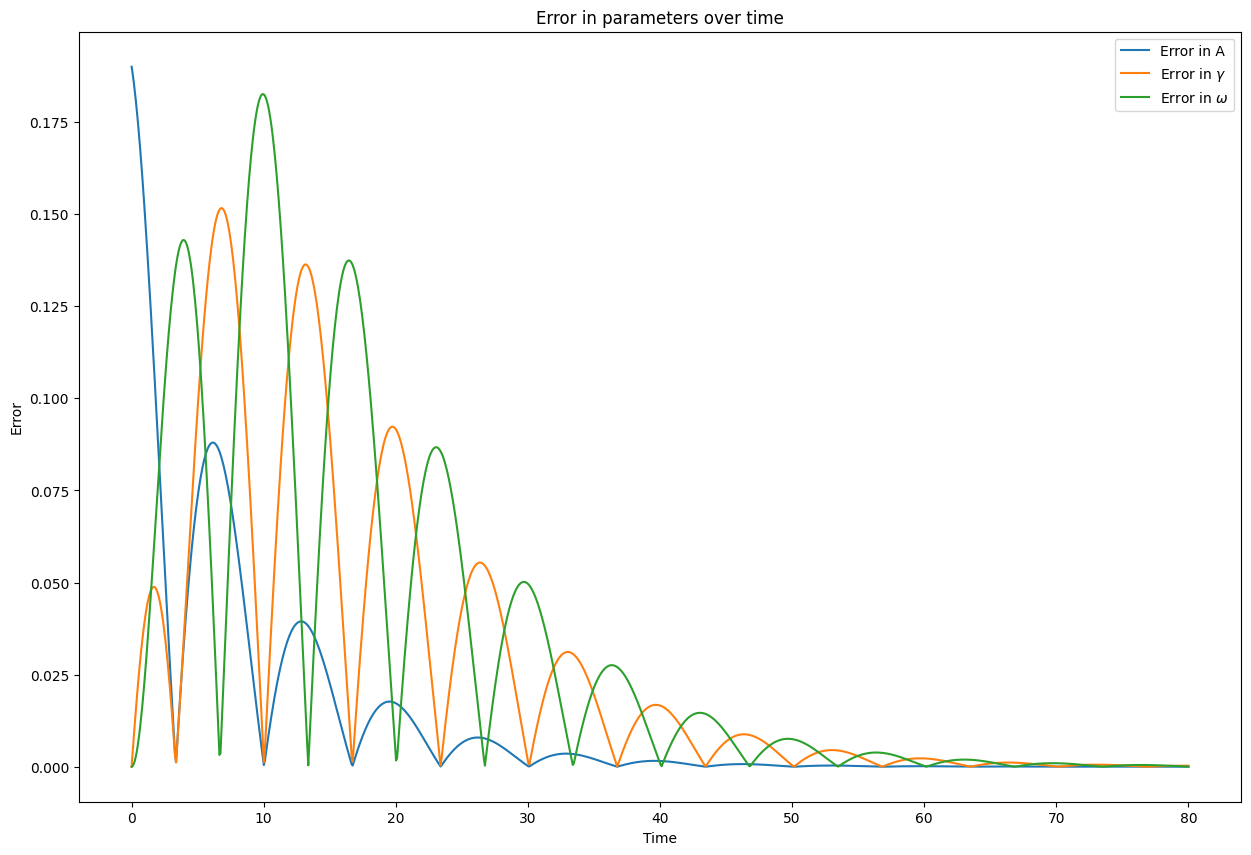

In [692]:
A, gamma, t, w = sp.symbols('A gamma t w')
sigma_A, sigma_gamma, sigma_w = sp.symbols('sigma_A sigma_gamma sigma_w')


#I differentiate the position with respect to the parameters to get the derivatives
dx_dA = sp.diff(Pos, A)
dx_dgamma = sp.diff(Pos, gamma)
dx_dw = sp.diff(Pos, w)

#I take each part of the errorpropagation formula and calculate the error for each parameter
error_A = sp.sqrt((dx_dA * sigma_A)**2)
error_gamma = sp.sqrt((dx_dgamma * sigma_gamma)**2)
error_w = sp.sqrt((dx_dw * sigma_w)**2)

#I can now lambidfy the error functions
Error_A = sp.lambdify((t, A, gamma, w, sigma_A), error_A)
Error_gamma = sp.lambdify((t, A, gamma, w, sigma_gamma), error_gamma)
Error_w = sp.lambdify((t, A, gamma, w, sigma_w), error_w)

A, gamma, w = 1.01, 0.12, 0.47
sigma_A, sigma_gamma, sigma_w= 0.19,0.05,0.06

t = np.linspace(0,80, 1000)
sigma_A_values = Error_A(t, A, gamma, w, sigma_A)
sigma_gamma_values = Error_gamma(t, A, gamma, w, sigma_gamma)
sigma_w_values = Error_w(t, A, gamma, w, sigma_w)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(t, sigma_A_values, label='Error in A')
ax.plot(t, sigma_gamma_values, label=r'Error in $\gamma$')
ax.plot(t, sigma_w_values, label=r'Error in $\omega$')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Error in parameters over time')
ax.legend()
plt.show()


I wanna see which parameters dominate during different times, so I will loop over steps of 10 and calculate the integral for each of the parameters and see which one is the largest.

C:\Users\Elias\AppData\Local\Temp\ipykernel_2976\3024143606.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(t_labels, rotation=45)


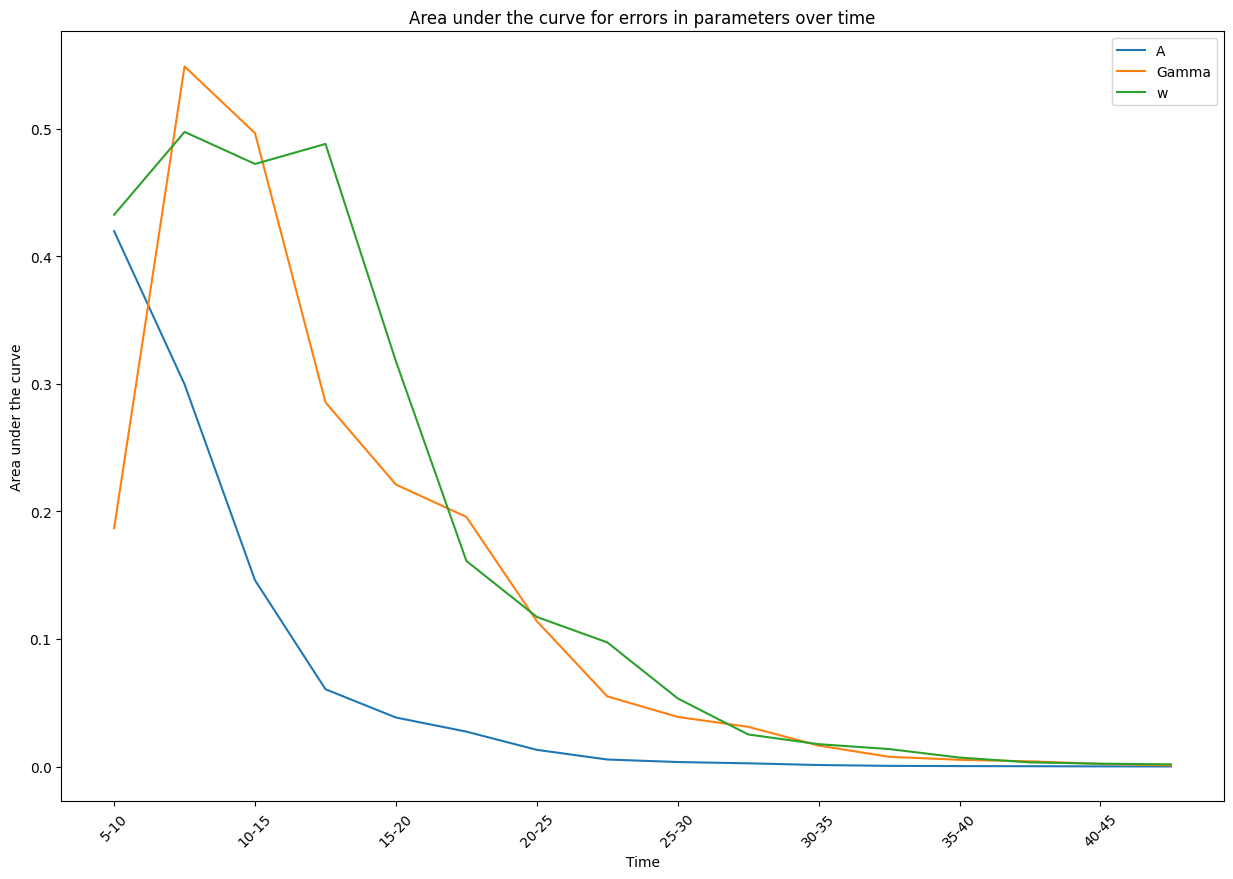

In [693]:
time_int = [(i, i+5) for i in range(0, 80, 5)]

A_area = []
gamma_area = []
w_area = []

A, gamma, w = 1.01, 0.12, 0.47
sigma_A, sigma_gamma, sigma_w= 0.19,0.05,0.06

for start, end in time_int:
    A_int = quad(Error_A, start, end, args=(A, gamma, w, sigma_A))[0]
    gamma_int = quad(Error_gamma, start, end, args=(A, gamma, w, sigma_gamma))[0]
    w_int = quad(Error_w, start, end, args=(A, gamma, w, sigma_w))[0]

    A_area.append(A_int)
    gamma_area.append(gamma_int)
    w_area.append(w_int)

t_labels = [f"{start}-{end}" for start, end in time_int]
t = np.arange(len(t_labels))

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(t, A_area, label='A')
ax.plot(t, gamma_area, label='Gamma')
ax.plot(t, w_area, label='w')
ax.set_xlabel('Time')
ax.set_xticklabels(t_labels, rotation=45)
ax.set_ylabel('Area under the curve')
ax.set_title('Area under the curve for errors in parameters over time')
ax.legend()

plt.show()


I see from the initial plot that from the start the uncertainty in A is the largest (t ~ 1), but after little time (t > 5) the uncertainty in $\gamma$ and $\omega$ is the largest and they follow each other closely untill all three are about the same (t > 45).

# ***III – Simulation / Monte Carlo:***

### 3.1  (10 points) You shoot a penalty, and the probability of scoring depends on the position x (in m)you hit, as pscore = |x|/4 m for |x| < 4 m and zero otherwise (outside goal). Assume the ball hits the goal where you aim with an uncertainty of one meter 

### • What is the chance of scoring, if you aim at x = 2.5m?

In [694]:
from scipy.stats import norm

r = np.random
r.seed(42)
# Parameters
aim_x = 2.5  # Aiming position (m)
uncertainty = 1.0  # Standard deviation of aiming uncertainty (m)
n_shots = 1000  # Number of Monte Carlo simulations

# Simulate shots
actual_hits = np.random.normal(aim_x, uncertainty, n_shots)  # Actual hit positions

def p_score(x):
    if abs(x) < 4:
        return abs(x)/4
    else:
        return 0


def simulate_scoring(x, sigma_x, num_shots):
    actual_hits = np.random.normal(x, sigma_x, num_shots)  # Actual hit positions

    pscore = np.array([p_score(x) for x in actual_hits])  # Scoring probabilities

    scores = np.random.uniform(0, 1, num_shots) < pscore  # Randomly decide if each shot scores

    chance_of_scoring = np.mean(scores) #Average of the scores
 
    return chance_of_scoring

chance_of_scoring = simulate_scoring(aim_x, uncertainty, n_shots)

print(f"Chance of scoring for x = {aim_x} +- {uncertainty} is p = {chance_of_scoring:.4f}")


Chance of scoring for x = 2.5 +- 1.0 is p = 0.5510


### • Where should you aim to have the highest probability of scoring?

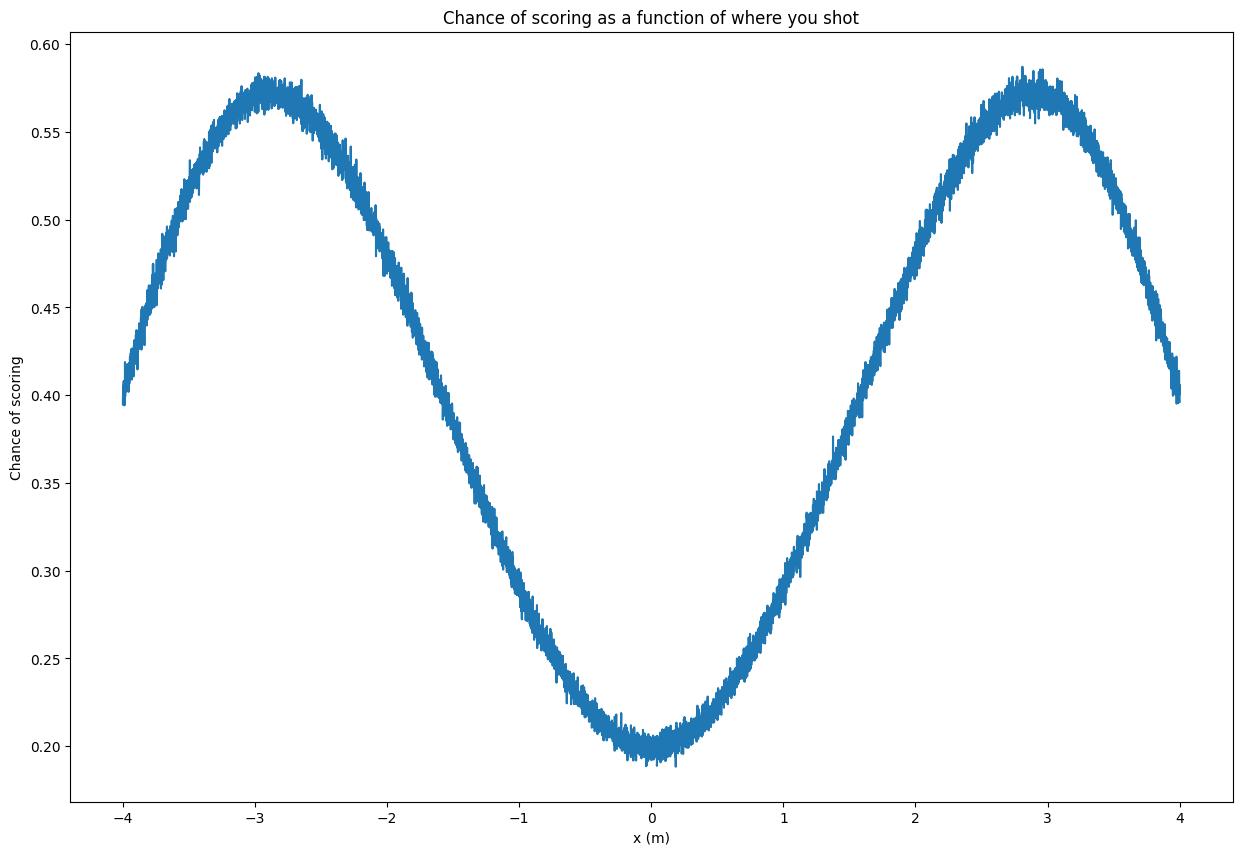

In [695]:
#Highest probability of scoring:
x_shots = np.linspace(-4, 4, 10000)
p_scores = np.array([simulate_scoring(x, 1, len(x_shots)) for x in x_shots])

plt.figure(figsize=(15, 10))
plt.plot(x_shots, p_scores)
plt.xlabel("x (m)")
plt.ylabel("Chance of scoring")
plt.title("Chance of scoring as a function of where you shot")
plt.show()


In [696]:
x_best_shot = x_shots[np.argmax(p_scores)]
print(f"Best shot is at x = {-x_best_shot:.2f} and {x_best_shot:.2f}")
print(f'The error in the best shot is {1/np.sqrt(len(x_shots)):.2f}')


Best shot is at x = -2.81 and 2.81
The error in the best shot is 0.01


## 3.2 (10 points) Consider the PDF f (x) = C_PDF(tan−1(x) + π/2) with x ∈ [−3, 3]

In [697]:
def f(x, C):
    return C*(np.arctan(x) + np.pi/2)

### • Determine C_PDF and generate 100 random numbers following f (x).

$$ f(x) = C_{PDF}(tan^{-1}(x) + \frac{\pi}{2}) $$

$$ F(x) = \int_{-3}^{3} C_{PDF}(tan^{-1}(x) + \frac{\pi}{2}) dx = 1 $$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) + \frac{\pi}{2} dx = 1 $$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + C_{PDF} \int_{-3}^{3} \frac{\pi}{2} dx  = 1$$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + C_{PDF} \frac{\pi}{2} \int_{-3}^{3} dx = 1$$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + C_{PDF} \frac{\pi}{2} [x]_{-3}^{3} = 1$$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + C_{PDF} \frac{\pi}{2} [3 - (-3)] = 1$$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + C_{PDF} \frac{\pi}{2} \cdot 6 = 1$$

$$ F(x) = C_{PDF} \int_{-3}^{3} tan^{-1}(x) dx + 3\pi C_{PDF} = 1$$

$$\int_{-3}^{3} tan^{-1}(x) = 0 $$

$$ 3\pi C_{PDF} = 1$$

$$ C_{PDF} = \frac{1}{3\pi} $$

Checking if I got the right normalization constant using scipy's quad:

In [698]:
def pdf(x):
    return C * (np.arctan(x) + np.pi / 2)

def integrand(x):
    return np.arctan(x) + np.pi / 2

normalization_constant, _ = quad(integrand, -3, 3)
C = 1 / normalization_constant
print(f"Normalization constant from quad: {C}")
print(f"Normalization constant from solving integral: {1/(3*np.pi)}")


Normalization constant from quad: 0.1061032953945969
Normalization constant from solving integral: 0.1061032953945969


$$ F(x) = \int_{-3}^{x} \frac{1}{3\pi}(tan^{-1}(x) + \frac{\pi}{2}) dx$$    

$$ F(x) = \frac{1}{3\pi} \int_{-3}^{x} tan^{-1}(x) + \frac{\pi}{2} dx$$

$$ F(x) = \frac{1}{3\pi} \int_{-3}^{x} tan^{-1}(x) dx + \frac{1}{3\pi} \int_{-3}^{x} \frac{\pi}{2} dx$$

$$ F(x) = \frac{1}{3\pi} \int_{-3}^{x} tan^{-1}(x) dx + \frac{1}{3\pi} \frac{\pi}{2} \int_{-3}^{x} dx$$

$$ F(x) = (x \cdot arctan(x)− \frac{1}{2} ln(1+x^2)]− [−3⋅arctan(−3)− \frac{1}{2}ln(1+(−3)^2)) + \frac{x+3}{6} = r$$





Since the equation is transcendental, I will instead use the accept/reject method to generate 100 random numbers following f(x).

In [699]:
xmin, xmax,ymin, ymax = -3, 3, 0, 1
#Accept/reject method
def accept_reject(N):
    x_accepted = np.zeros(N)
    N_try = 0
    for i in range(N):
        while True:
            x = np.random.uniform(xmin, xmax)
            y = np.random.uniform(ymin, ymax)
            if y < f(x, (1/(3*np.pi))):
                x_accepted[i] = x
                break
            N_try += 1
    return x_accepted, N_try

N = 100
N_1000 = 1000
x_100, N_100_try = accept_reject(N)
x_1000, N_1000_try = accept_reject(N_1000)


print(f"Accept/reject method: {N_100_try} tries for 100 points")
print(f"Accept/reject method: {N_1000_try} tries for 1000 points")


Accept/reject method: 409 tries for 100 points
Accept/reject method: 4943 tries for 1000 points


In [700]:
eff_100 = N / N_1000_try
eff_1000 = N_1000 / N_1000_try
eff_error_100 = np.sqrt(eff_100*(1-eff_100)/N_100_try)
eff_error_1000 = np.sqrt(eff_1000*(1-eff_1000)/N_1000_try)
integral_100 = eff_100*(xmax-xmin)*(ymax-ymin)
integral_1000 = eff_1000*(xmax-xmin)*(ymax-ymin)
integral_error_100 = eff_error_100*(xmax-xmin)*(ymax-ymin)
integral_error_1000 = eff_error_1000*(xmax-xmin)*(ymax-ymin)

print(f"Integral of g(x) = x*cos(x), x in [0, pi/2] is: \t {integral_100:7.4f} +- {integral_error_100:6.4f} for 100 points")
print(f"Integral of g(x) = x*cos(x), x in [0, pi/2] is: \t {integral_1000:7.4f} +- {integral_error_1000:6.4f} for 1000 points")
print(f"The efficiency of the accept/reject method is:  \t {eff_100:.2%} +/- {eff_error_100:.2%} for 100 points")
print(f"The efficiency of the accept/reject method is:  \t {eff_1000:.2%} +/- {eff_error_1000:.2%} for 1000 points")


Integral of g(x) = x*cos(x), x in [0, pi/2] is: 	  0.1214 +- 0.0418 for 100 points
Integral of g(x) = x*cos(x), x in [0, pi/2] is: 	  1.2138 +- 0.0343 for 1000 points
The efficiency of the accept/reject method is:  	 2.02% +/- 0.70% for 100 points
The efficiency of the accept/reject method is:  	 20.23% +/- 0.57% for 1000 points


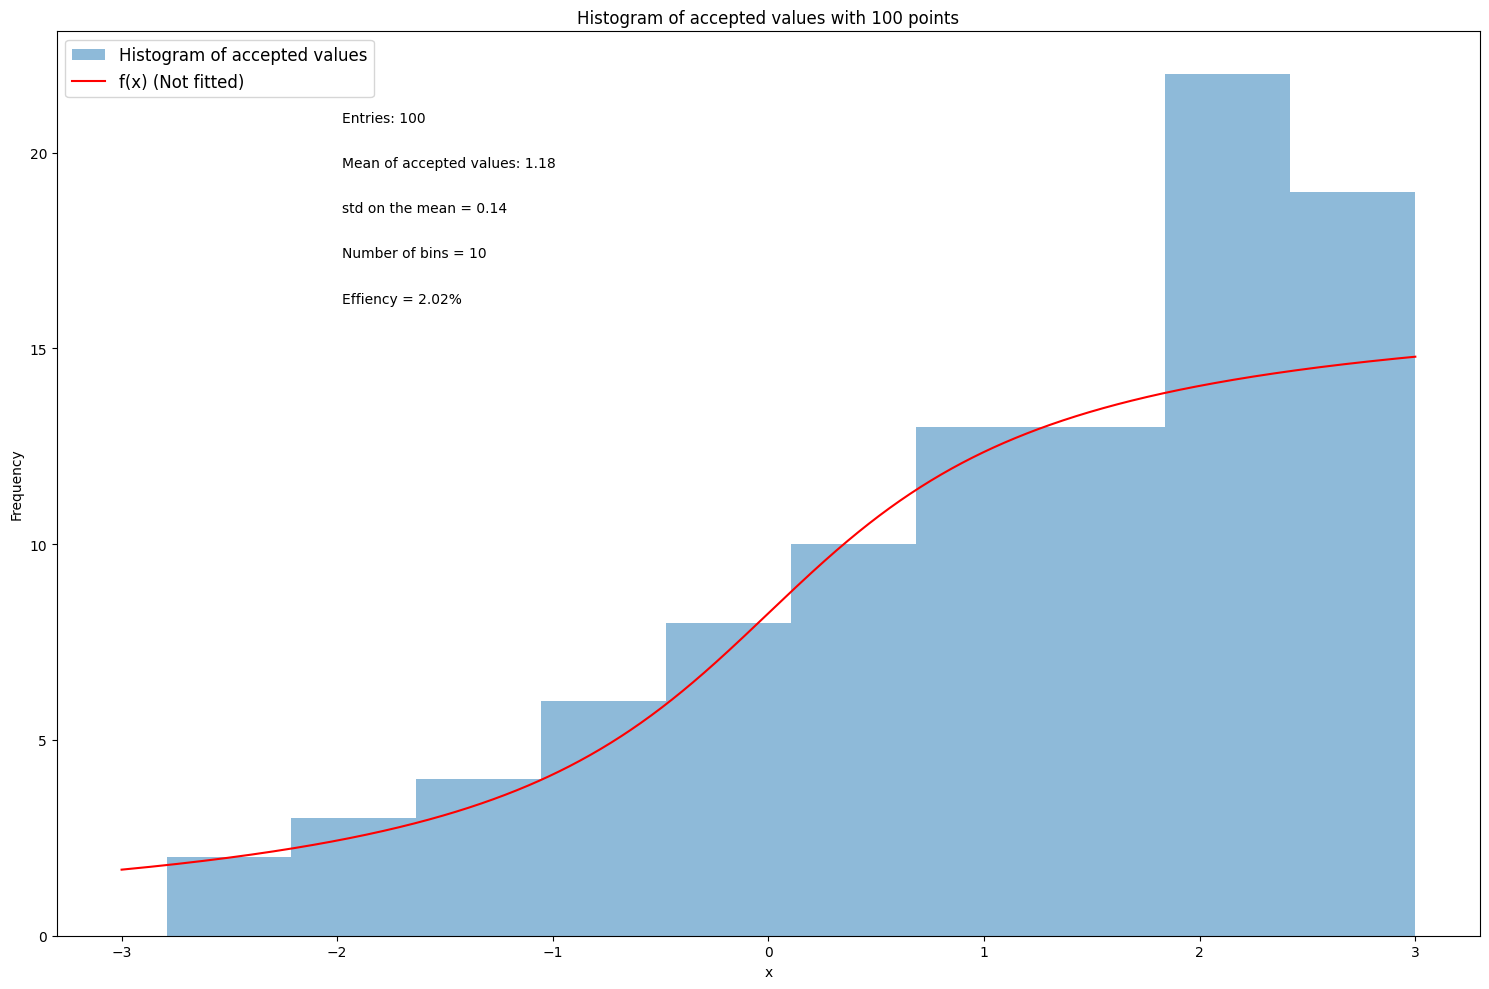

In [701]:
Nbins = 10

def func_plot(x, N, integral):
    k = (xmax-xmin)/Nbins
    N_norm = N * k
    return N_norm * 1/integral* f(x, (1/(3*np.pi)))


# Plotting the histogram
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(x_100, bins=Nbins, alpha=0.5, label="Histogram of accepted values")
ax.set(xlabel="x", ylabel="Frequency", title="Histogram of accepted values with 100 points")

# Plotting my function on top of the histogram
x = np.linspace(xmin, xmax, 1000)
y = func_plot(x, 10, integral_100)
ax.plot(x, y, 'r', label="f(x) (Not fitted)")

plot_info = [f'Entries: {len(x_100)}', 
f'Mean of accepted values: {np.mean(x_100):.2f}', 
f'std on the mean = {np.std(x_100)/np.sqrt(len(x_100)):.2f}',
f'Number of bins = {Nbins}',
f'Effiency = {eff_100:.2%}']

for i, txt in enumerate(plot_info):
    ax.annotate(txt, (0.2, 0.9 - i*0.05), xycoords='axes fraction')

ax.legend(loc = 'best', fontsize = 'large')
fig.tight_layout()


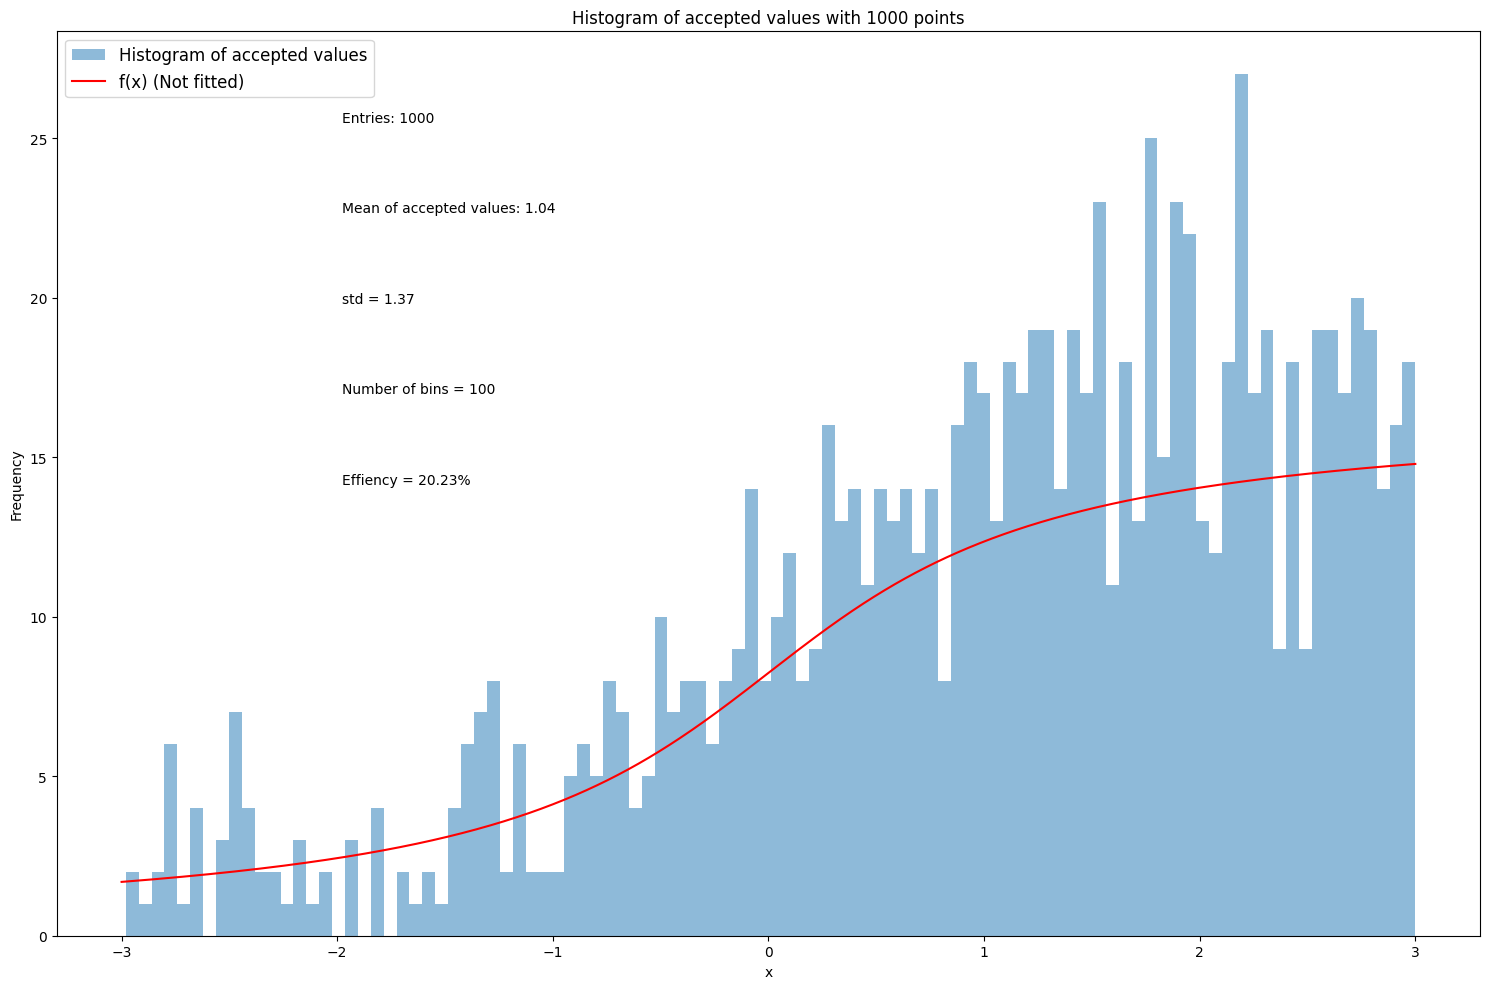

In [702]:

Nbins = 100
# Plotting the histogram
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax2.hist(x_1000, bins=Nbins, alpha=0.5, label="Histogram of accepted values")
ax2.set(xlabel="x", ylabel="Frequency", title="Histogram of accepted values with 1000 points")

# Plotting my function on top of the histogram
x = np.linspace(xmin, xmax, 1000)
y = func_plot(x, N_1000, integral_1000)
ax2.plot(x, y, 'r', label="f(x) (Not fitted)")

plot_info = [f'Entries: {len(x_1000)}', 
f'Mean of accepted values: {np.mean(x_1000):.2f}', 
f'std = {np.std(x_1000):.2f}',
f'Number of bins = {Nbins}',
f'Effiency = {eff_1000:.2%}']

for i, txt in enumerate(plot_info):
    ax2.annotate(txt, (0.2, 0.9 - i*0.1), xycoords='axes fraction')

ax2.legend(loc = 'best', fontsize = 'large')
fig2.tight_layout()


It seems as though having only 100 points is not enough to get a good representation of the PDF. Therefore I used 1000 points instead. I will then use minuit to fit the PDF to the data and see if I get the same normalization constant as I calculated above.

Value of C from minuit: 0.11633356768421033 +- 0.003880883101292024
Value of C from integral: 0.1061032953945969
Chi2: 101.44, ndof: 97, p-value: 0.36


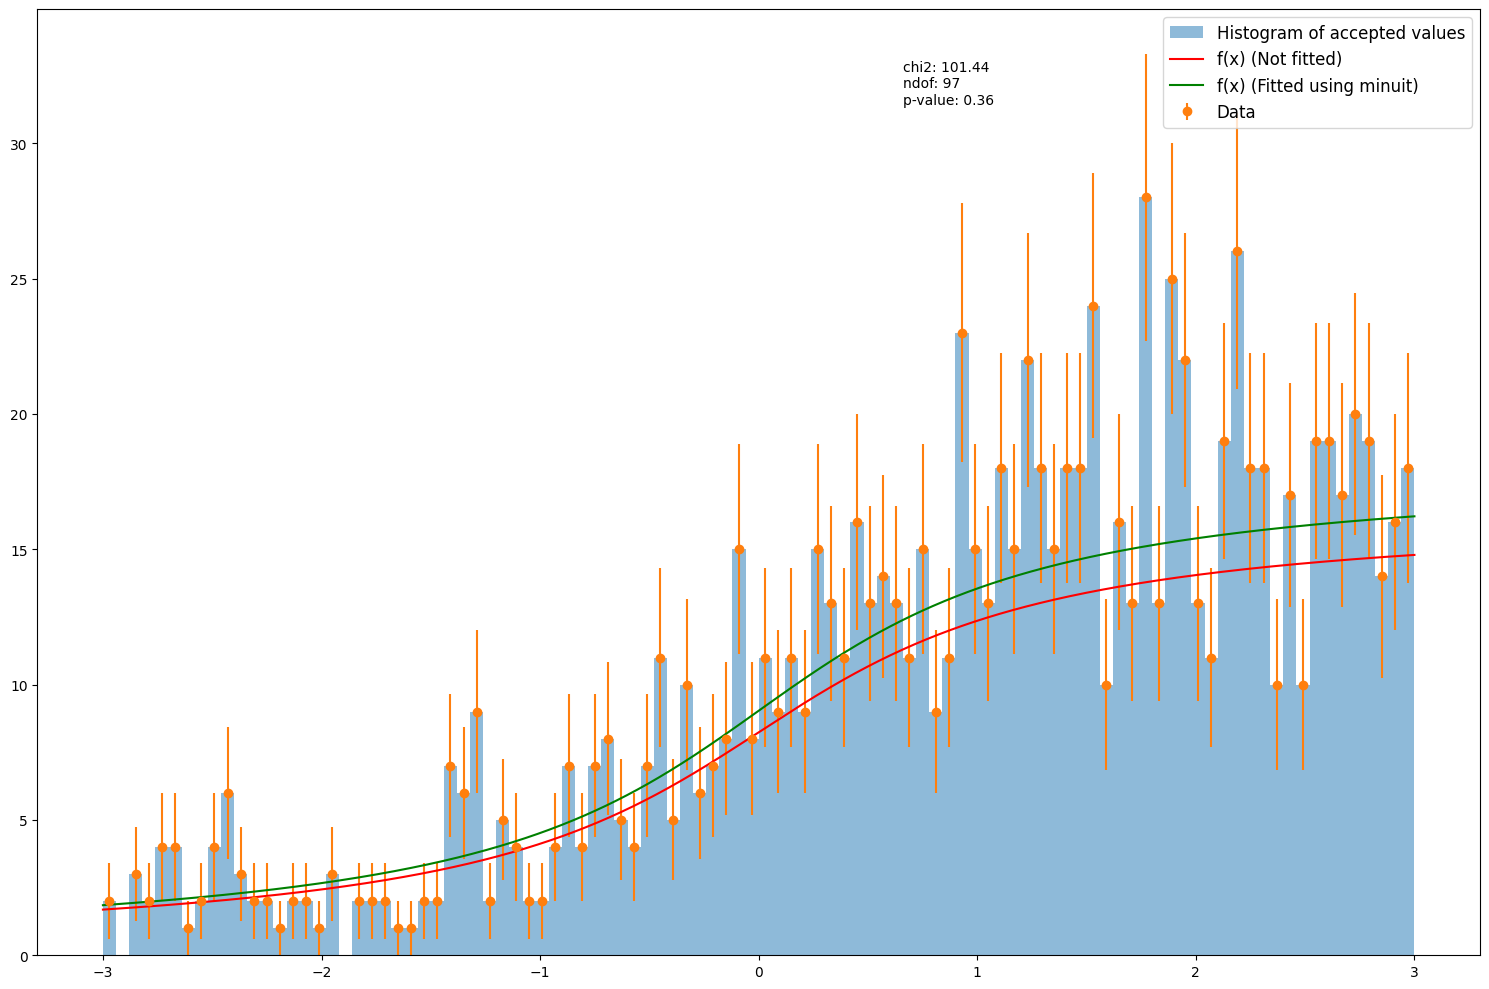

In [703]:
fig3, ax3 = plt.subplots(figsize=(15, 10))

integral = integral_1000
N = N_1000
Nbins = 100

def func_plot_m(x, C):
    k = (xmax-xmin)/Nbins
    N_norm = N * k
    return N_norm * 1/integral*f(x, C)

counts, bin_edges, _ = plt.hist(x_1000, bins=Nbins, range = (xmin, xmax), alpha=0.5, label="Histogram of accepted values")
x = (bin_edges[1:] + bin_edges[:-1])/2
x = x[counts>0]
y = counts[counts>0]
yerr = np.sqrt(y)

ax3.errorbar(x, y, yerr, fmt='o', label='Data')

x2 = np.linspace(xmin, xmax, 1000)
y2 = func_plot(x2, N_1000, integral_1000)
ax3.plot(x2, y2, 'r', label="f(x) (Not fitted)")

#Using minuit to try and fit to the data/histogram
fit = cost.LeastSquares(x, y, yerr, func_plot_m)
mfit = Minuit(fit, C=1)
mfit.migrad()

print('Value of C from minuit:', mfit.values['C'], '+-', mfit.errors['C'])
print('Value of C from integral:', 1/(3*np.pi))

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_plot_m(x_fit, mfit.values['C'])

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

print(f"Chi2: {chi2:.2f}, ndof: {ndof}, p-value: {prob:.2f}")

ax3.plot(x_fit, y_fit, 'g', label="f(x) (Fitted using minuit)")
ax3.annotate(f'chi2: {chi2:.2f} \nndof: {ndof} \np-value: {prob:.2f}', (0.6, 0.9), xycoords='axes fraction')
ax3.legend(loc = 'best', fontsize = 'large')
fig3.tight_layout()




As the p-value is 0.36 I cannot reject the null hypothesis that the data is consistent with the PDF.

In [704]:
z_test = (mfit.values['C'] - 1/(3*np.pi)) / mfit.errors['C']
print(f"z-test: {z_test:.2f}")
prob = stats.norm.sf(z_test)
print(f"p-value: {prob:.2f}")

z-test: 2.64
p-value: 0.00


This tells me my value is within 2.64 sigma of what minuit calculated, which is within reason.

Value of C from minuit: 0.11951209879223768 +- 0.012406540475438056
Value of C from integral: 0.1061032953945969
Chi2: 7.21, ndof: 9, p-value: 0.62


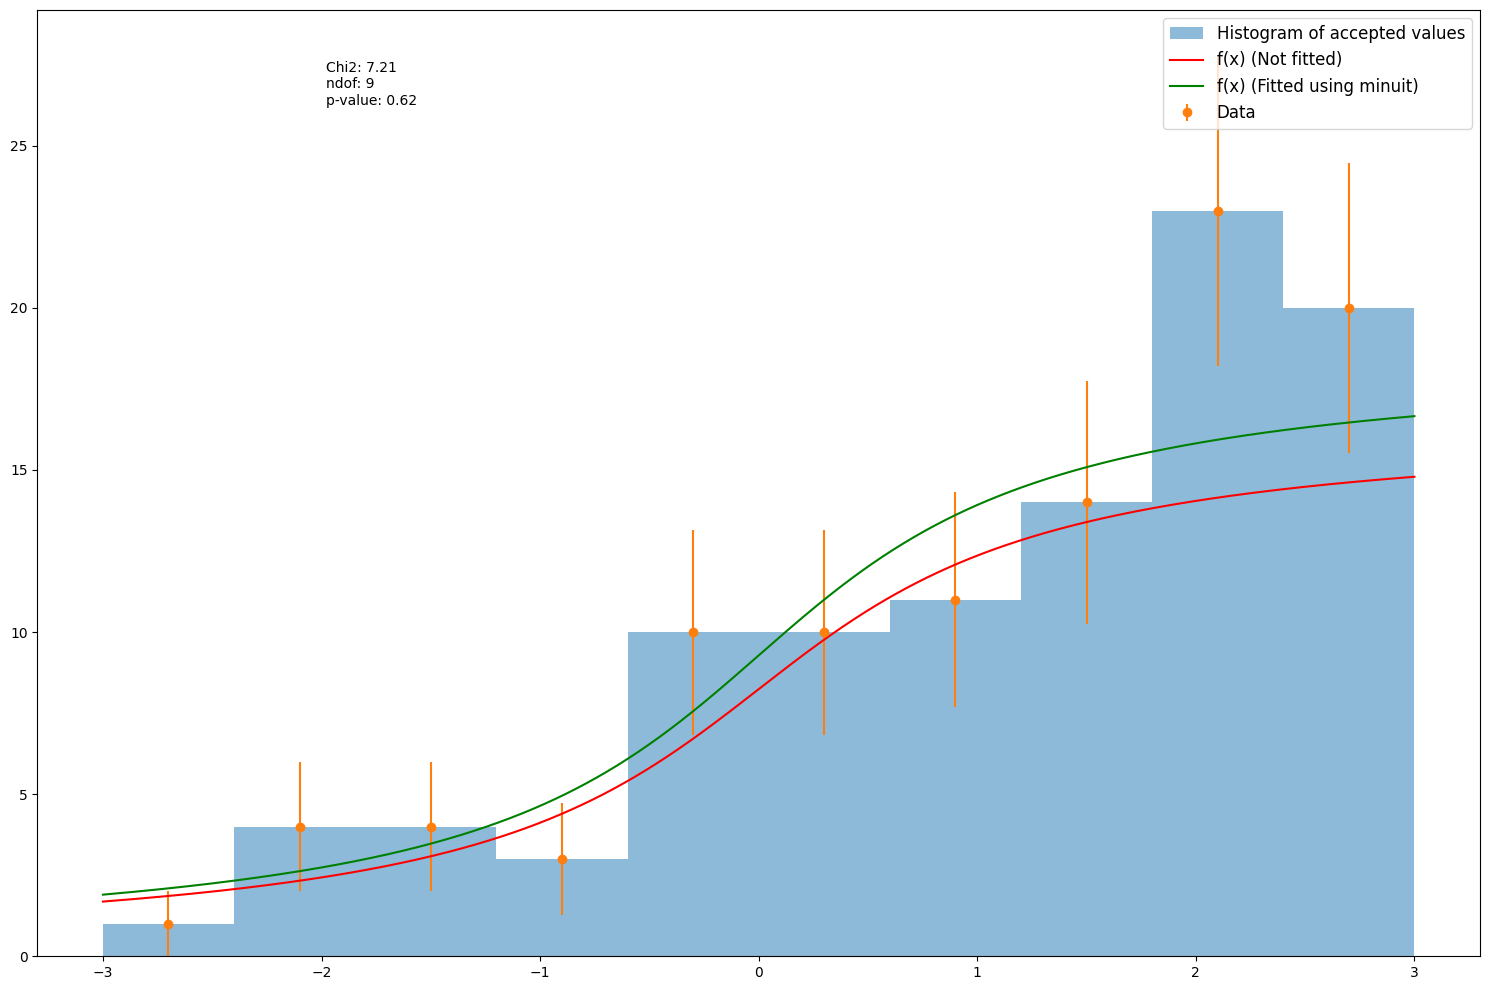

In [705]:
fig4, ax4 = plt.subplots(figsize=(15, 10))

integral = integral_100
N = 100
Nbins = 10

def func_plot_m(x, C):
    k = (xmax-xmin)/Nbins
    N = 10
    N_norm = N * k
    return N_norm* 1/integral*f(x, C)

counts, bin_edges, _ = plt.hist(x_100, bins=Nbins, range = (xmin, xmax), alpha=0.5, label="Histogram of accepted values")
x = (bin_edges[1:] + bin_edges[:-1])/2
x = x[counts>0]
y = counts[counts>0]
yerr = np.sqrt(y)

ax4.errorbar(x, y, yerr, fmt='o', label='Data')

x3 = np.linspace(xmin, xmax, 1000)
y3 = func_plot_m(x3, C=1/(3*np.pi))
ax4.plot(x3, y3, 'r', label="f(x) (Not fitted)")

#Using minuit to try and fit to the data/histogram
fit = cost.LeastSquares(x, y, yerr, func_plot_m)
mfit = Minuit(fit, C=1)
mfit.migrad()

print('Value of C from minuit:', mfit.values['C'], '+-', mfit.errors['C'])
print('Value of C from integral:', 1/(3*np.pi))

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_plot_m(x_fit, mfit.values['C'])

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

print(f"Chi2: {chi2:.2f}, ndof: {ndof}, p-value: {prob:.2f}")

ax4.plot(x_fit, y_fit, 'g', label="f(x) (Fitted using minuit)")
ax4.annotate(f'Chi2: {chi2:.2f}\nndof: {ndof}\np-value: {prob:.2f}', (0.2, 0.9), xycoords='axes fraction')
ax4.legend(loc = 'best', fontsize = 'large')
fig4.tight_layout()

In [706]:
z_test = (mfit.values['C'] - 1/(3*np.pi)) / mfit.errors['C']
print(f"z-test: {z_test:.2f}")
prob = stats.norm.sf(z_test)
print(f"p-value: {prob:.2f}")

z-test: 1.08
p-value: 0.14


### ***IV Statistical tests***

## 4.1 (10 points) The file www.nbi.dk/∼petersen/data LargestPopulation.csv contains data on the Indian and Chinese population each year in the period 1960-2021.

In [707]:
Populations = pd.read_csv('data_LargestPopulation.csv')

def chi2(O, E):
    return np.sum((O - E)**2 / E)

### • Linearly ﬁt the Indian population 1963-1973, and estimate the data point uncertainty.

In [708]:
Population_lin = Populations[3:14]


Fit parameters from curvefit a = 11745303 +- 133981, b = -22579730731 +- 263675688
Estimated errors on data points: 1271059


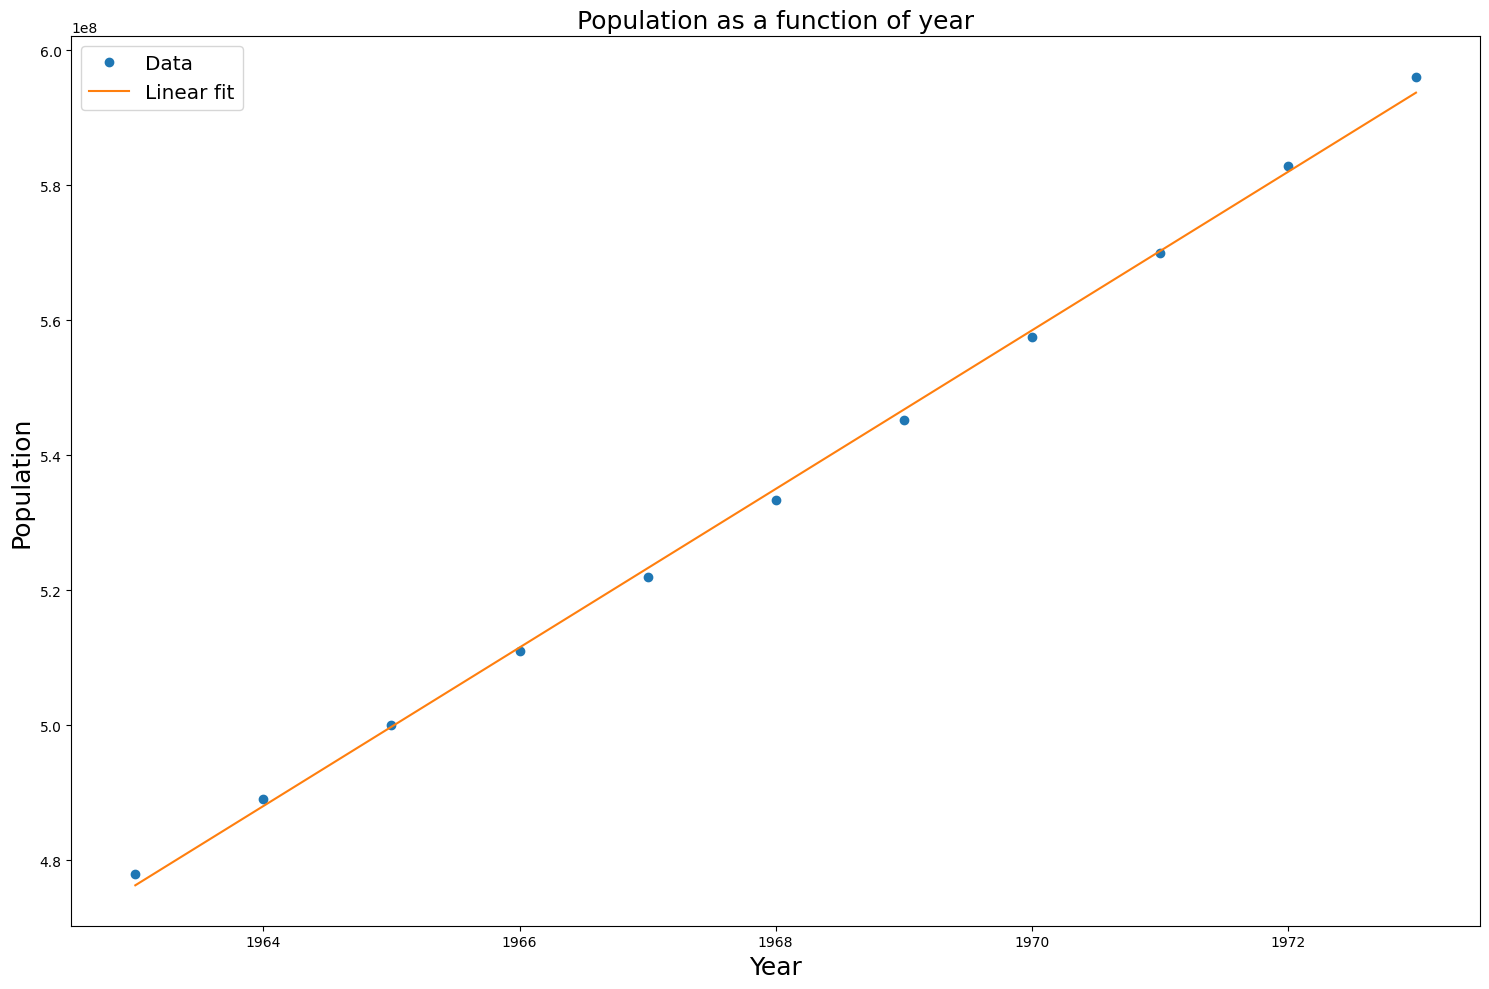

In [709]:
# Fit a linear model

def linear(x, a, b):
    return a*x + b

pop, cov = curve_fit(linear, Population_lin['Year'], Population_lin['    PopIndia'])

a, b = pop  # Parameters from curvefit
a_error, b_error = np.sqrt(np.diag(cov))  # Errors from curvefit

x = np.linspace(1963, 1973, 1000)
y = linear(x, a, b)

residual = Population_lin['    PopIndia'] - linear(Population_lin['Year'], a, b)
errors = np.std(residual)

print(f'Fit parameters from curvefit a = {a:.0f} +- {a_error:.0f}, b = {b:.0f} +- {b_error:.0f}')
print(f'Estimated errors on data points: {errors:.0f}')

# Plotting the data and the fit
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Population_lin['Year'], Population_lin['    PopIndia'], 'o', label='Data')
ax.plot(x, y, label='Linear fit')
ax.set(xlabel='Year', ylabel='Population', title='Population as a function of year')
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Population', fontsize=18)
ax.set_title('Population as a function of year', fontsize=18)
ax.legend(loc='best', fontsize='x-large')
fig.tight_layout()

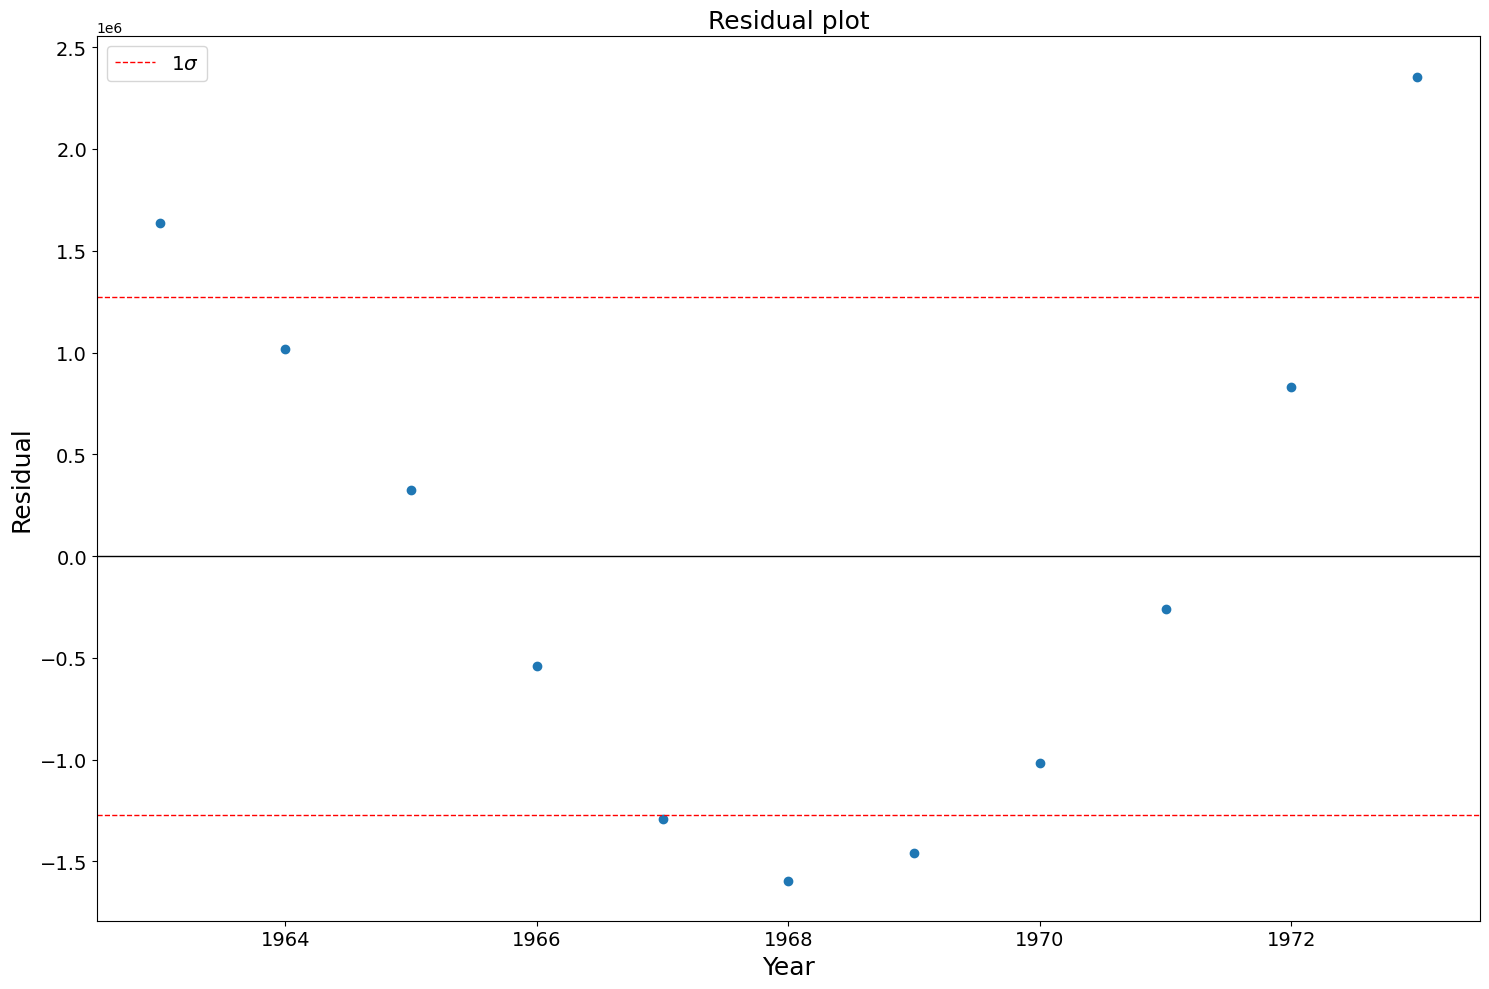

In [710]:
#reisudal plot

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Population_lin['Year'], residual, 'o')
ax.axhline(0, color='black', lw=1)
ax.axhline(errors, color='red', lw=1, ls='--', label='1$\sigma$')
ax.axhline(-errors, color='red', lw=1, ls='--')
ax.set(xlabel='Year', ylabel='Residual', title='Residual plot')	
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Residual', fontsize=18)
ax.set_title('Residual plot', fontsize=18)
ax.legend(loc='best', fontsize='x-large')
fig.tight_layout()

### • Assuming an uncertainty of ±1000000 on all data points, model the population developments and give your best estimate of when the Indian population overtakes the Chinese

In [711]:
print(Populations)

    Year      PopIndia        PopChina
0   1960     445954560       654170700
1   1961     456351870       655260350
2   1962     467024200       664614660
3   1963     477933630       683903550
4   1964     489059300       704593800
..   ...           ...             ...
57  2017    1354195700      1410276000
58  2018    1369003300      1417069400
59  2019    1383112100      1421864100
60  2020    1396387100      1424929800
61  2021    1407563900      1425893500

[62 rows x 3 columns]


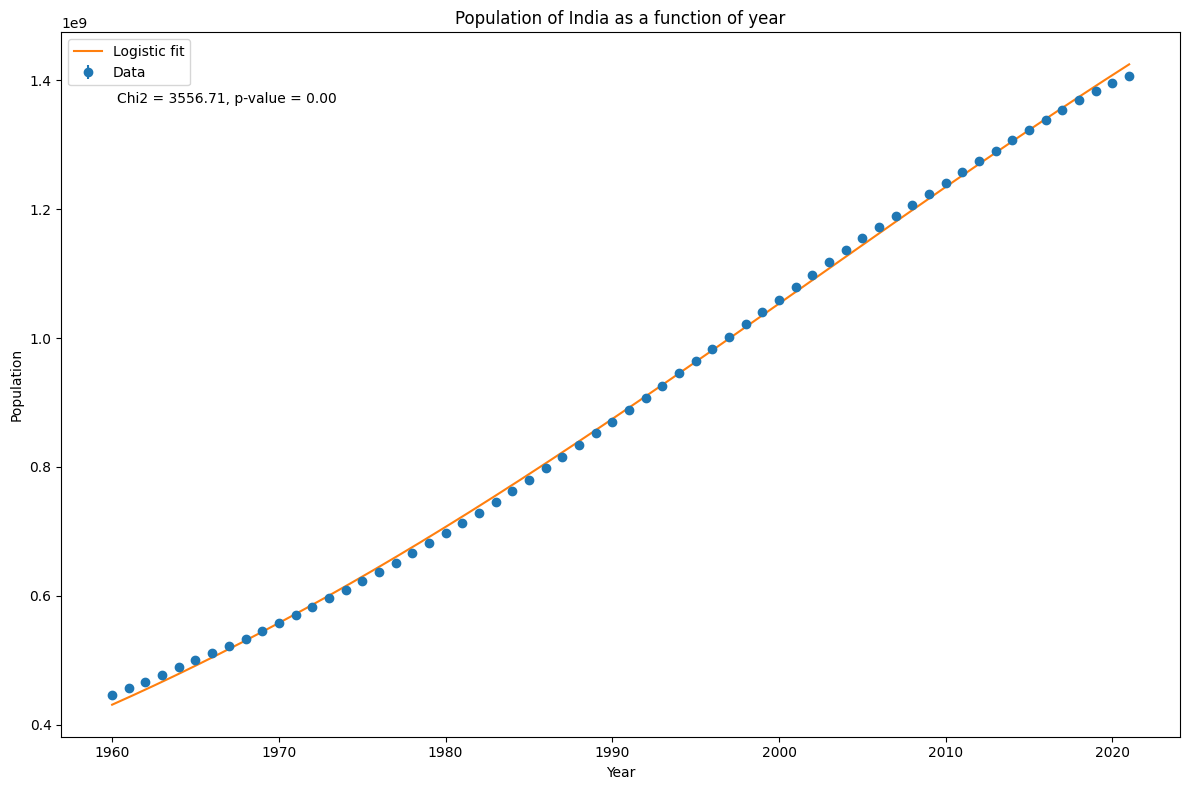

In [712]:
population_error = 1000000 * np.ones(len(Populations)) 

# def logistic(x, L, k, x_0):
#     return L / (1 + np.exp(-k* (x - x_0)))
def logistic(x, P_0, r, K):
    return K / (1 + ((K - P_0) / P_0) * np.exp(-r * x))

years = Populations['Year'] - Populations['Year'].min()
pop_india = Populations['    PopIndia']
pop_china = Populations['      PopChina']


#Using minuit to fit the logistic function to the data

fit_india = cost.LeastSquares(years, pop_india, population_error, logistic)
fit_china = cost.LeastSquares(years, pop_china, population_error, logistic)
initial_guess_india = {'P_0': pop_india.min(), 'r': 0.01, 'K': 2.2*pop_india.max()}
initial_guess_china = {'P_0': pop_china.min(), 'r': 0.01, 'K': 2.2*pop_china.max()}

bounds = {'P_0': (4e8, 5e9), 'r': (0.001, 0.2), 'K': (1e9, 1e10)} #Bounds for the parameters, but does not seem to work

mfit_india = Minuit(fit_india, **initial_guess_india)
mfit_china = Minuit(fit_china, **initial_guess_china)
# mfit.limits = bounds
mfit_india.migrad()
mfit_china.migrad()
if (not mfit_india.fmin.is_valid) or (not mfit_china.fmin.is_valid):
    print("Fit did not converge")
    mfit.hesse()
    mfit.minos()

x = np.linspace(0, 61, 1000)
y_india = logistic(x, mfit_india.values['P_0'], mfit_india.values['r'], mfit_india.values['K'])
y_china = logistic(x, mfit_china.values['P_0'], mfit_china.values['r'], mfit_china.values['K'])


chi2 = mfit_india.fval
ndof = len(Populations) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

chi2_china = mfit_china.fval
ndof_china = len(Populations) - len(mfit.values)
prob_china = stats.chi2.sf(chi2_china, ndof_china)

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(years + Populations['Year'].min(), pop_india, yerr=population_error, fmt='o', label='Data')
ax.plot(x + Populations['Year'].min(), y_india, label='Logistic fit')
ax.set(xlabel='Year', ylabel='Population', title='Population of India as a function of year')
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.05, 0.9), xycoords='axes fraction')
ax.legend(loc='best')
fig.tight_layout()




I have a really low p-value, which could indicate that the erros are underestimated, and it seems minuit is having problem with the covariance matrix of some of the parameters.

The populations of India and China are equal in the year 2021 according to my model


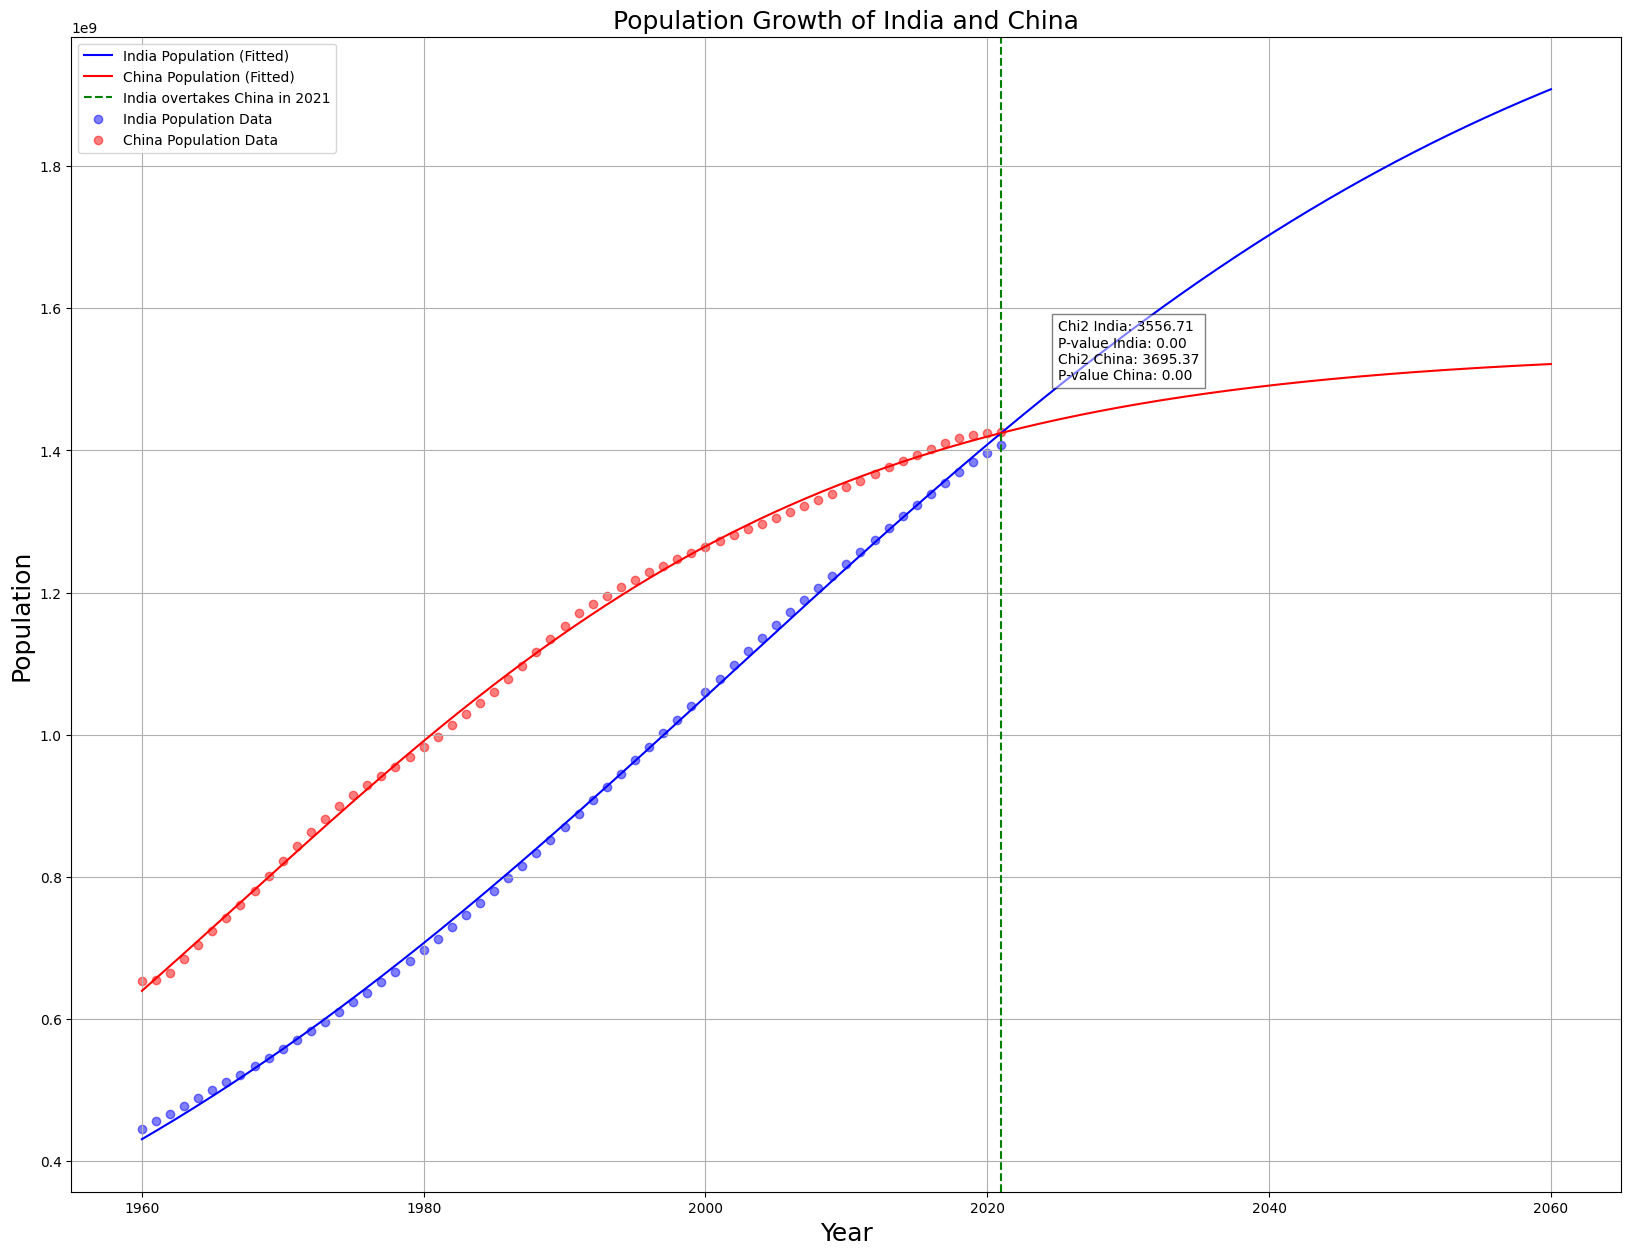

In [713]:
def year_overtake(years):
    years = years - Populations['Year'].min()
    return logistic(years, mfit_india.values['P_0'], mfit_india.values['r'], mfit_india.values['K']) - logistic(years, mfit_china.values['P_0'], mfit_china.values['r'], mfit_china.values['K'])

solution = root_scalar(year_overtake, bracket=[2020, 2100], method='brentq')    
intersection = solution.root

print(f'The populations of India and China are equal in the year {intersection:.0f} according to my model')

years_future = np.linspace(1960, 2100, 500)
pop_india_future = logistic(years_future, *mfit_india.values)
pop_china_future = logistic(years_future, *mfit_china.values)

x_f = np.linspace(0, 100, 1000)
y_india = logistic(x_f, mfit_india.values['P_0'], mfit_india.values['r'], mfit_india.values['K'])
y_china = logistic(x_f, mfit_china.values['P_0'], mfit_china.values['r'], mfit_china.values['K'])


plt.figure(figsize=(20, 15))
plt.plot(x_f + Populations['Year'].min(), y_india, label="India Population (Fitted)", color="blue")
plt.plot(x_f + Populations['Year'].min() , y_china, label="China Population (Fitted)", color="red")
plt.axvline(intersection, color="green", linestyle="--", label=f"India overtakes China in {intersection:.0f}")
plt.scatter(Populations['Year'], pop_india, color="blue", alpha = 0.5, label="India Population Data")
plt.scatter(Populations['Year'], pop_china, color="red", alpha = 0.5, label="China Population Data")
plt.text(2025, 1.5e9, f'Chi2 India: {chi2:.2f}\nP-value India: {prob:.2f}\nChi2 China: {chi2_china:.2f}\nP-value China: {prob_china:.2f}', 
         bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel("Year", fontsize=18)
plt.ylabel("Population", fontsize = 18)
plt.legend()
plt.title("Population Growth of India and China", fontsize = 18)
plt.grid()
plt.show()

To improve on this and try and estimate an error on my estimate overtake year, I will run some monte carlo simulations. I will generate 1000 random numbers for each year in the range of the error and fit the data to each of these. I will then calculate the mean and standard deviation of the overtake year.

In [714]:
n_sim = 100
overtake_years = []


for i in range(n_sim):
     #This will give add random noise to the data in order to simulate the uncertainty of the error
    pop_india_sim = pop_india + np.random.normal(0, population_error, len(pop_india))
    pop_china_sim = pop_china + np.random.normal(0, population_error, len(pop_china))

    #I proceed as before
    fit_india = cost.LeastSquares(years, pop_india_sim, population_error, logistic)
    fit_china = cost.LeastSquares(years, pop_china_sim, population_error, logistic)

    mfit_india = Minuit(fit_india, **initial_guess_india)
    mfit_china = Minuit(fit_china, **initial_guess_china)

    mfit_india.migrad()
    mfit_china.migrad()

    solution = root_scalar(year_overtake, bracket=[2020, 2100], method='brentq')
    intersection = solution.root
    overtake_years.append(intersection)

overtake_years = np.array(overtake_years)
mean_overtake = np.mean(overtake_years)
std_on_the_mean_overtake = np.std(overtake_years)


print(f'The populations of India and China are equal in the year {mean_overtake:.2f} +- {std_on_the_mean_overtake:.2f} according to my simulation')
   

The populations of India and China are equal in the year 2020.99 +- 0.04 according to my simulation


### 4.2 (5 points) A medical experiment is testing if a drug has a speciﬁc side eﬀect. Out of 24 persons taking the drug, 10 had the side eﬀect. For 24 other persons getting a placebo, only 5 had the side eﬀect. Would you claim that the drug has this side eﬀect?

My $H_0$ hypothesis is that the drug does not have the side effect and the proportion of people experincing is the same for the drug and the placebo

I will look at two distinct ways of testing this hypothesis. The first is to use the z-test test and the second is to use the chi2-test. I will then compare the two results and see if they agree.

First I will define proportions of people experiencing the side effect and use this to in my test with a significance level of 0.05. I'm using a pooled proportion since I'm assuming that the drug and placebo have the same proportion of people experiencing the side effect. - https://en.wikipedia.org/wiki/Z-test

In [715]:
#z-test
n = 24

x_drug = 10
x_placebo = 5

p_drug = x_drug/n
p_placebo = x_placebo/n

pooled = (x_drug + x_placebo) / (2*n)

z = (p_drug - p_placebo) / np.sqrt(pooled*(1-pooled)*(1/n + 1/n))

p_value = stats.norm.sf(z)*2 #Two sided test since the proportion can both be higher or lower

print(f'z-test: {z:.2f}, p-value: {p_value:.2f}')

z-test: 1.56, p-value: 0.12


As my p-value is > 0.05 I cannot reject the null hypothesis that the drug does not have the side effect.

I will now use the chi2-test to test the same hypothesis. I will use the same significance level of 0.05 and use scipy's chi2_contingency function to calculate the independence of variables of the two proportions: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html


In [716]:
#chi2-test
from scipy.stats import chi2_contingency

data_drug = np.array([[x_drug, n-x_drug], [x_placebo, n-x_placebo]])

chi2, p_value, dof, expected = chi2_contingency(data_drug)

print(f'chi2: {chi2:.2f}, p-value: {p_value:.2f}')

chi2: 1.55, p-value: 0.21


Again I cannot reject the null hypothesis that the drug does not has the side effect.

I would simply from this, very sparse data, conclude that I can at least not reject that the drug does not have the side effect.

### Smartphone producer claims that their phones (A) have a battery lifetime that is signiﬁcantly longer than that of a rival phone (B). You measure the lifetime of the batteries (inhours) ﬁve times for each brand (table below). Test if the claim is reasonable.

My $H_0$ hypothesis is that the battery lifetime of the two phones are the same. And I will perform a t-test to test this hypothesis as I have a low number of samples.

In [717]:
from scipy.stats import ttest_ind

A = np.array([28.9,26.4,22.8,27.3,25.9])
B = np.array([22.4,21.3,25.1,24.8,22.5])


t_statistic, p_value = ttest_ind(A, B, alternative='greater')

print(f'T-statistic: {t_statistic:.2f}')
print(f'P-value: {p_value:.4f}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Phone A has longer battery lifetime than phone B.")
else:
    print("Fail to reject the null hypothesis")

T-statistic: 2.44
P-value: 0.0203
Reject the null hypothesis: Phone A has longer battery lifetime than phone B.


# ***V – Fitting data***

### 5.1 (18 points) The file www.nbi.dk/∼petersen/data SignalDetection.csv contains 120000 entries with values of measured phase (P ), resonance (R), frequency (ν), and type (signal/noise).In the first 100000 entries (control sample) it is known if the measurements are signal (1) or noise(0). In the last 20000 entries (real sample) this is unknown

### • Plot the control sample frequency distribution. Fit the observed H-peak at ν = 1.42 GHz.

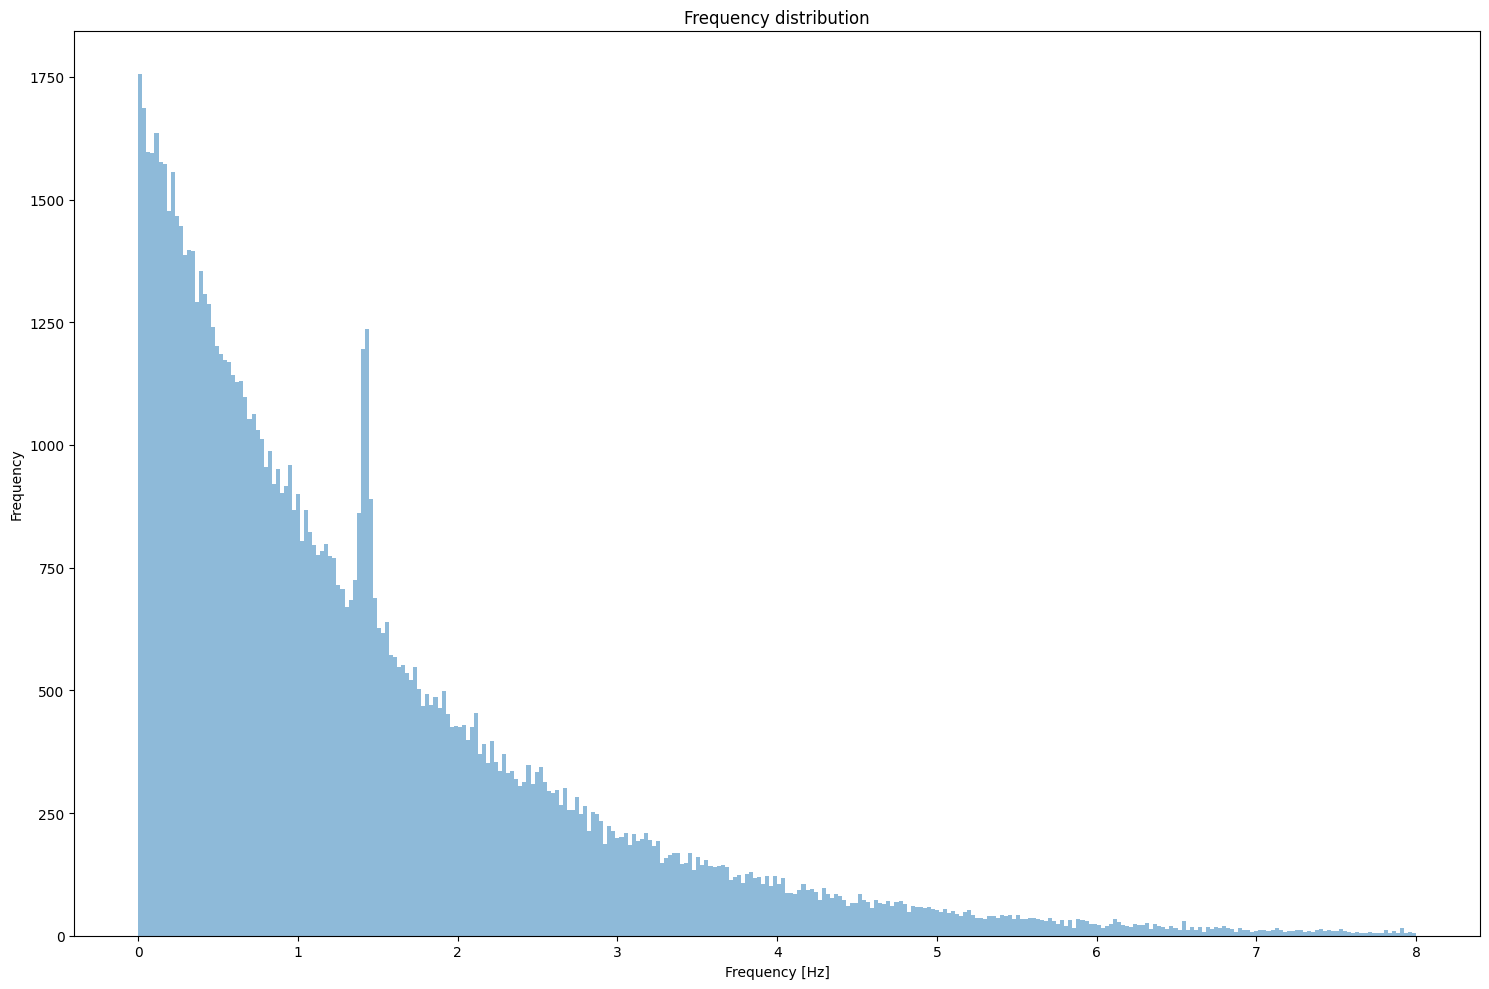

In [718]:
Signal = pd.read_csv('data_SignalDetection.csv')
phase = Signal['     Phase']
resonance = Signal['    Resonance']
freq = Signal[' Frequency']


control_phase = phase[:100000]
control_resonance = resonance[:100000]
control_freq = freq[:100000]

real_phase = phase[100000:]
real_resonance = resonance[100000:]
real_freq = freq[100000:]
#Frequency distribution
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(control_freq, bins=int(np.sqrt(100000)), alpha=0.5, range=(0,8), label="Frequency distribution")
ax.set(xlabel="Frequency [Hz]", ylabel="Frequency", title="Frequency distribution")
fig.tight_layout()



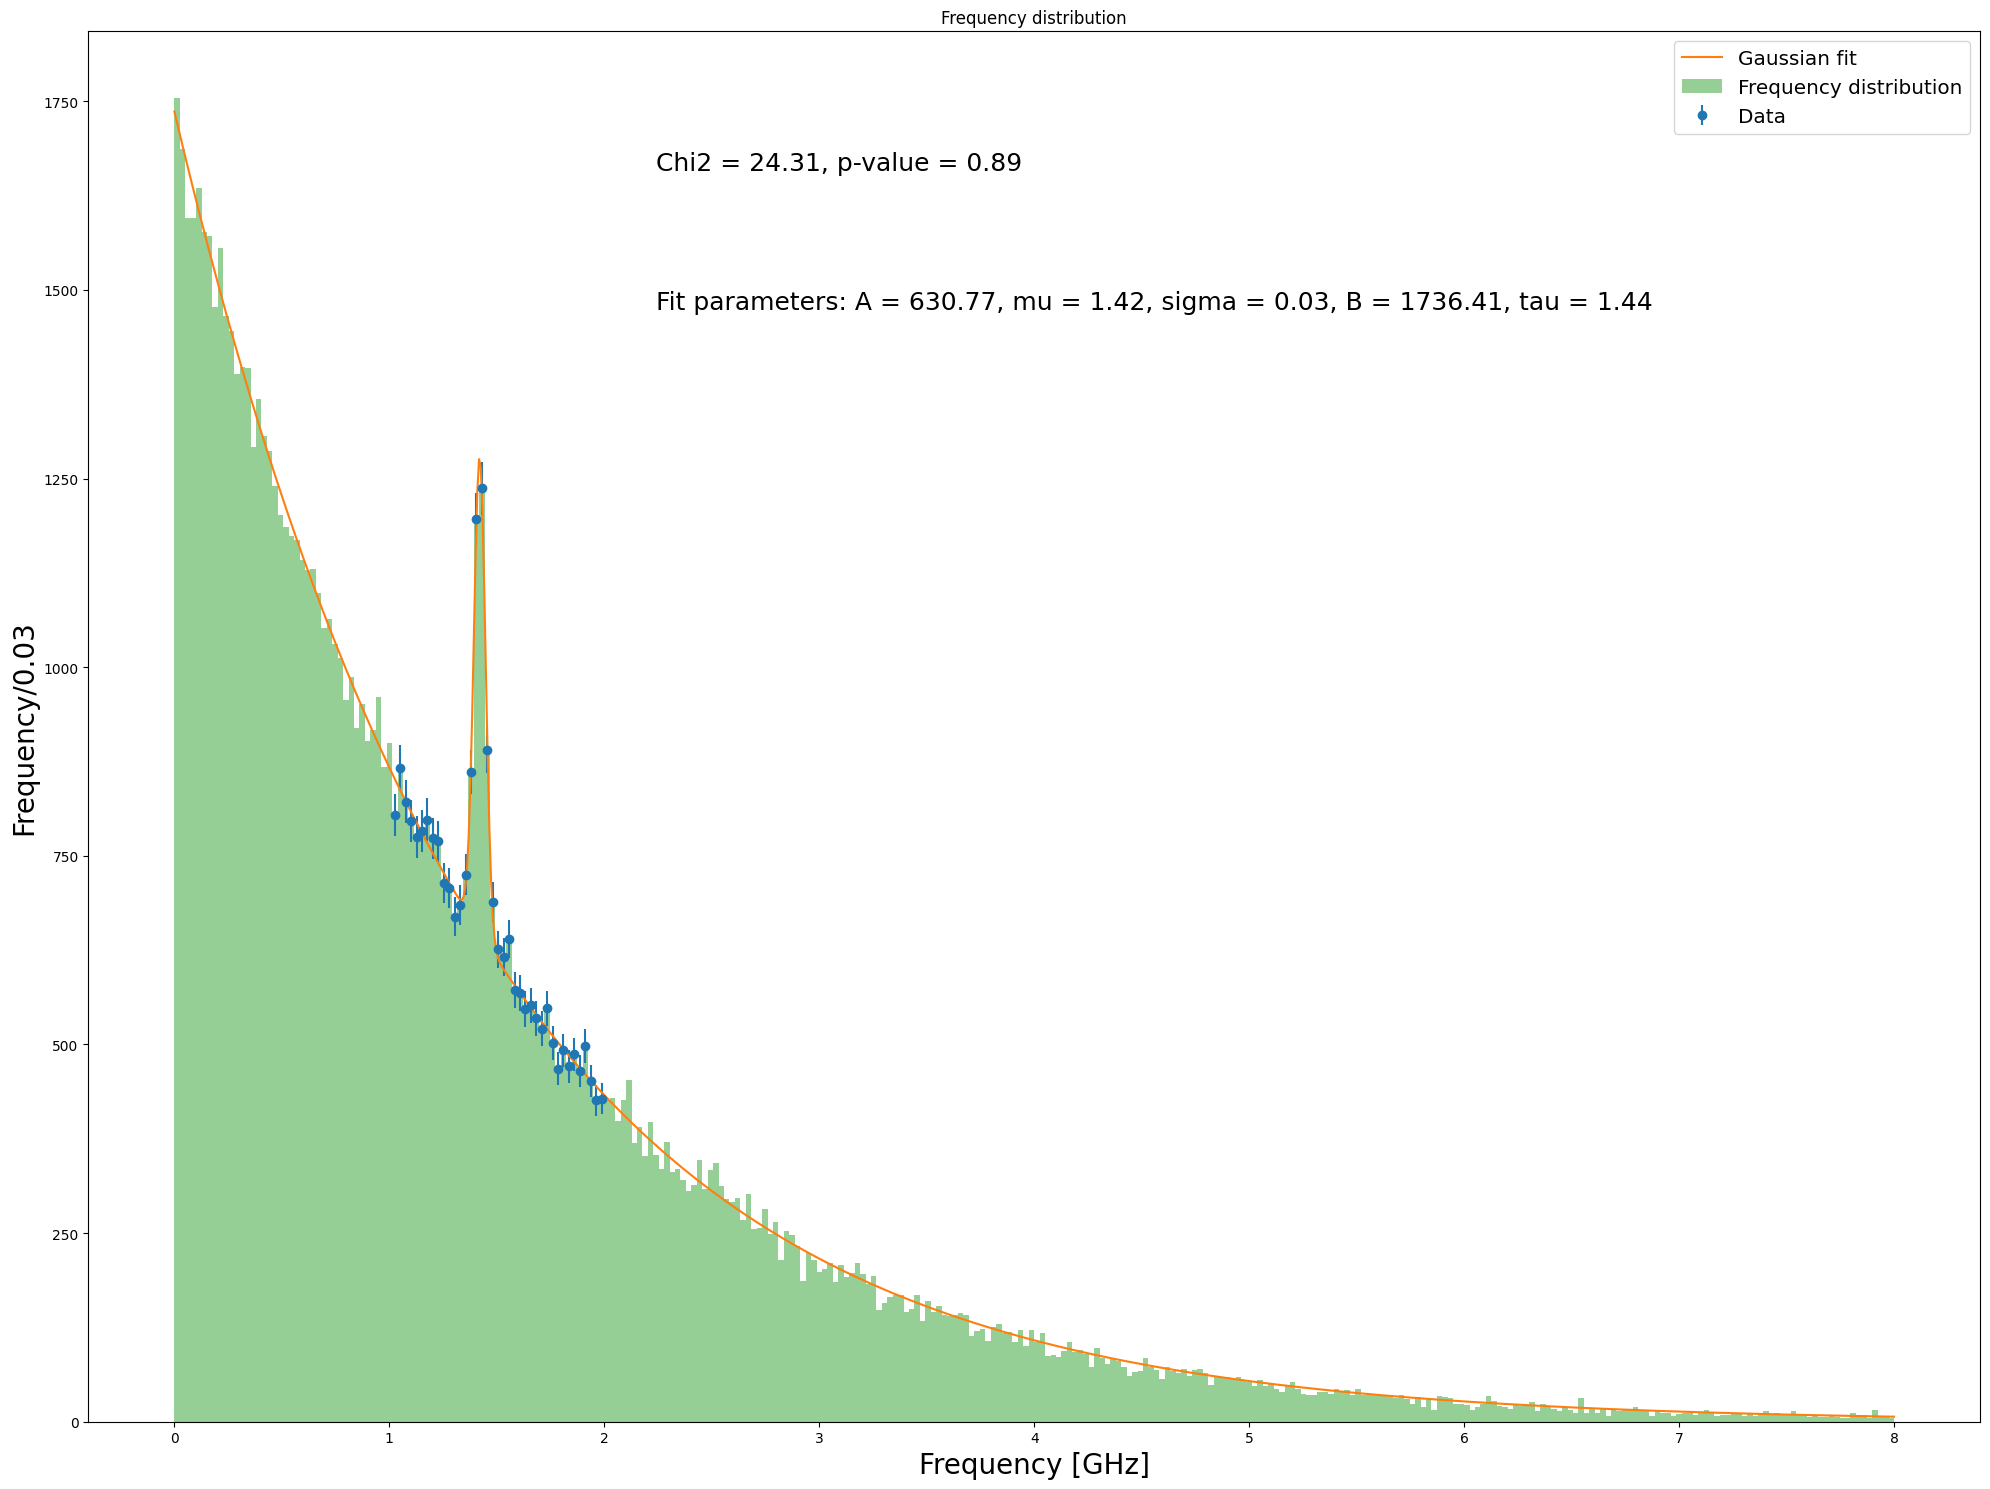

In [746]:
### Fitting the data
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, tau):
    return B * np.exp(-x / tau)

def fit_function(x, A, mu, sigma, B, tau):
    return gaussian(x, A, mu, sigma) + exponential(x, B, tau)

bins, edges = np.histogram(control_freq, bins=int(np.sqrt(100000)), range=(0, 8))
bin_width2 = edges[1] - edges[0]
x = (edges[1:] + edges[:-1]) / 2
y = bins
yerr = np.sqrt(y)

mask = (x > 1) & (x < 2)
x = x[mask]
y = y[mask]
yerr = yerr[mask]

fit = cost.LeastSquares(x, y, yerr, fit_function)
mfit = Minuit(fit, A=200, mu=1.42, sigma=0.1, B = 1750, tau=0.5)
mfit.migrad()

x_fit = np.linspace(0, 8, 1000)
y_fit = fit_function(x_fit,*mfit.values)

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

fig, ax = plt.subplots(figsize=(20, 15))
ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label='Gaussian fit')
ax.hist(control_freq, bins=int(np.sqrt(100000)), alpha=0.5, range=(0,8), label="Frequency distribution")
ax.set(xlabel='Frequency [GHz]', ylabel='Frequency', title='Frequency distribution')
ax.set_xlabel('Frequency [GHz]', fontsize=20)
ax.set_ylabel(f'Frequency/{bin_width2:.2f}', fontsize=20)
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.3, 0.9), xycoords='axes fraction', fontsize=18)
ax.annotate(f'Fit parameters: A = {mfit.values["A"]:.2f}, mu = {mfit.values["mu"]:.2f}, sigma = {mfit.values["sigma"]:.2f}, B = {mfit.values["B"]:.2f}, tau = {mfit.values["tau"]:.2f}', (0.3, 0.8), xycoords='axes fraction', fontsize=18)
ax.legend(loc='best', fontsize='x-large')
fig.tight_layout()

plt.savefig('Frequency_distribution.png')




In [720]:
lower_bound = mfit.values['mu'] - mfit.values['sigma']
upper_bound = mfit.values['mu'] + mfit.values['sigma']
Entries_in_peak = control_freq[(control_freq > lower_bound) & (control_freq < upper_bound)].shape[0]
print(f'Total entries = {control_freq.shape[0]}')
print(f'Entries in peak: {Entries_in_peak:.0f} +- {mfit.errors["A"]:.0f}')


Total entries = 100000
Entries in peak: 2560 +- 31


In [721]:
print(f'Significancy of the peak: {Entries_in_peak/control_freq.shape[0]:.2%}')

Significancy of the peak: 2.56%


Here I use both a gaussion and an exponential function to fit the data, as I see most of the data looks exponential with the peak acting gaussion.

### • Quantify how well you can separate signal from noise using the variables P and R

First I need to seperate the signal and noise data and luckily I know for the first 100000 entries, wheter its noise or signal from the type column

In [722]:
control_phase_signal = control_phase[Signal['   Type'] == 1]
control_resonance_signal = control_resonance[Signal['   Type'] == 1]

control_phase_noise = control_phase[Signal['   Type'] == 0]
control_resonance_noise = control_resonance[Signal['   Type'] == 0]

control_signal = np.array([control_phase_signal, control_resonance_signal]).T
control_noise = np.array([control_phase_noise, control_resonance_noise]).T

mu_signal = np.mean(control_signal, axis=0)
mu_noise = np.mean(control_noise, axis=0)


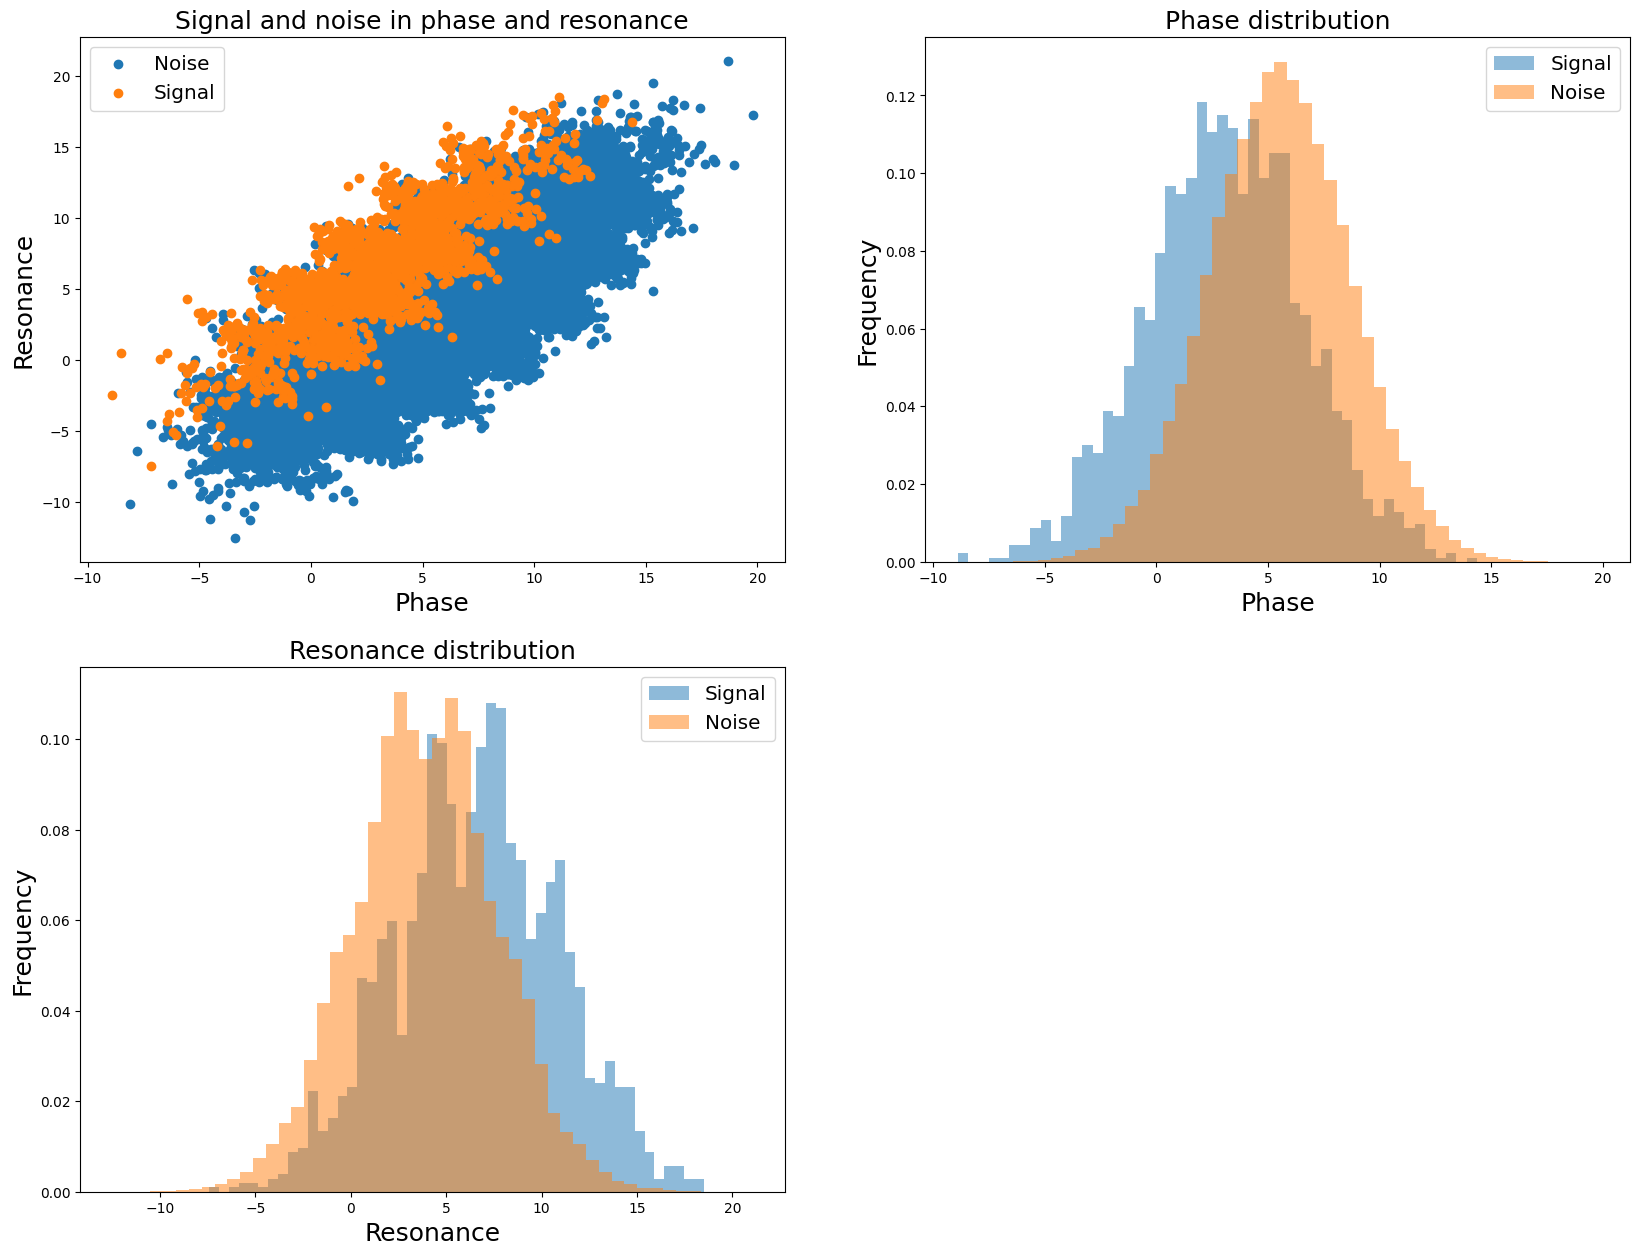

In [723]:
#Doing a scatter plot of noise and signal of phase and resonance
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0, 0].scatter(control_phase_noise, control_resonance_noise, label='Noise')
ax[0, 0].scatter(control_phase_signal, control_resonance_signal, label='Signal')
ax[0, 0].set(xlabel='Phase', ylabel='Resonance', title='Signal and noise in phase and resonance')
ax[0, 0].set_xlabel('Phase', fontsize=18)
ax[0, 0].set_ylabel('Resonance', fontsize=18)
ax[0, 0].set_title('Signal and noise in phase and resonance', fontsize=18)
ax[0, 0].legend(loc='best', fontsize='x-large')

ax[0, 1].hist(control_phase_signal, bins=50, density = True, alpha=0.5, label='Signal')
ax[0, 1].hist(control_phase_noise, bins=50, density = True, alpha=0.5, label='Noise')
ax[0, 1].set(xlabel='Phase', ylabel='Frequency', title='Phase distribution')
ax[0,1].set_xlabel('Phase', fontsize=18)
ax[0,1].set_ylabel('Frequency', fontsize=18)
ax[0,1].set_title('Phase distribution', fontsize=18)
ax[0, 1].legend(loc='best', fontsize='x-large')

ax[1, 0].hist(control_resonance_signal, bins=50, density = True, alpha=0.5, label='Signal')
ax[1, 0].hist(control_resonance_noise, bins=50, density = True, alpha=0.5, label='Noise')
ax[1, 0].set(xlabel='Resonance', ylabel='Frequency', title='Resonance distribution')
ax[1,0].set_xlabel('Resonance', fontsize=18)
ax[1,0].set_ylabel('Frequency', fontsize=18)
ax[1,0].set_title('Resonance distribution', fontsize=18)
ax[1, 0].legend(loc='best', fontsize='x-large')

# ax[1, 1].scatter(mu_phase, mu_resonance)
ax[1, 1].axis('off')

plt.savefig('Signal_noise.png')




In [724]:
def get_covariance_offdiag(X, Y):
    return np.cov(X, Y, ddof=1)[0, 1]

def calc_separation(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    d = np.abs((mean_x - mean_y)) / np.sqrt(std_x**2 + std_y**2)
    
    return d

In [725]:
covmat_PR_control_noise = np.cov(control_phase_noise, control_resonance_noise, ddof = 1)
covmat_PR_control_signal = np.cov(control_phase_signal, control_resonance_signal, ddof = 1)

In [726]:
cov_sum = covmat_PR_control_noise + covmat_PR_control_signal
cov_sum_inv = np.linalg.inv(cov_sum)
print(f'Inverse of the sum of the covariance matrices:\n{cov_sum_inv}')

Inverse of the sum of the covariance matrices:
[[ 0.11109629 -0.07167262]
 [-0.07167262  0.07792198]]


I then use this to calculate the ficher coefficients

In [727]:
print(mu_signal.shape)
wf = cov_sum_inv @ (mu_signal - mu_noise)
print(f'Weighting factor for Phase-Resonance control: {wf}')

(2,)
Weighting factor for Phase-Resonance control: [-0.46483767  0.38510219]


In [728]:
fischer_P_signal = control_signal @ wf
fischer_P_noise = control_noise @ wf

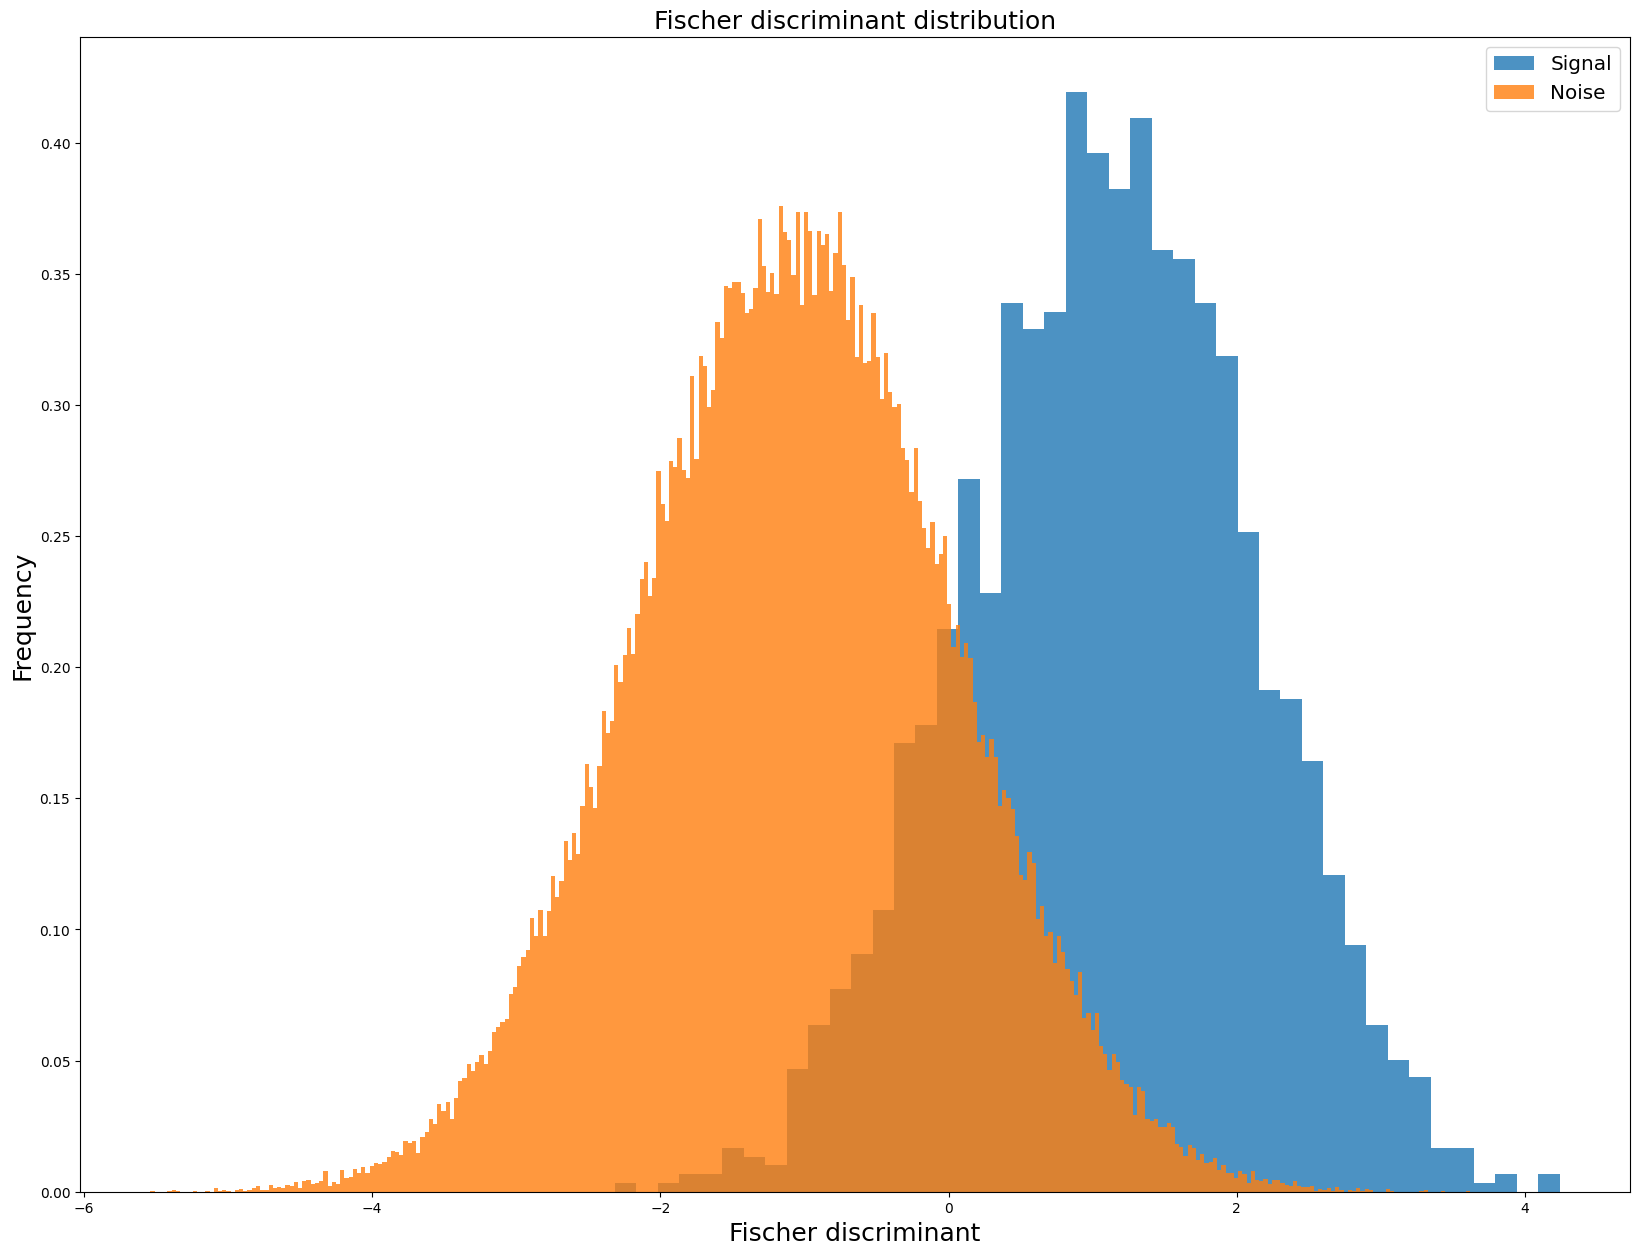

In [729]:
fig_fischer, ax_fischer = plt.subplots(figsize=(20, 15))
ax_fischer.hist(fischer_P_signal, bins=int(np.sqrt(len(fischer_P_signal))), alpha=0.8, density=True, label='Signal')
ax_fischer.hist(fischer_P_noise, bins=int(np.sqrt(len(fischer_P_noise))), alpha=0.8, density = True, label='Noise')
ax_fischer.set(xlabel='Fischer discriminant', ylabel='Frequency', title='Fischer discriminant distribution')
ax_fischer.set_xlabel('Fischer discriminant', fontsize=18)
ax_fischer.set_ylabel('Frequency', fontsize=18)
ax_fischer.set_title('Fischer discriminant distribution', fontsize=18)
ax_fischer.legend(loc='best', fontsize='x-large')

plt.savefig('Fischer_discriminant.png')


0.28943296002192653


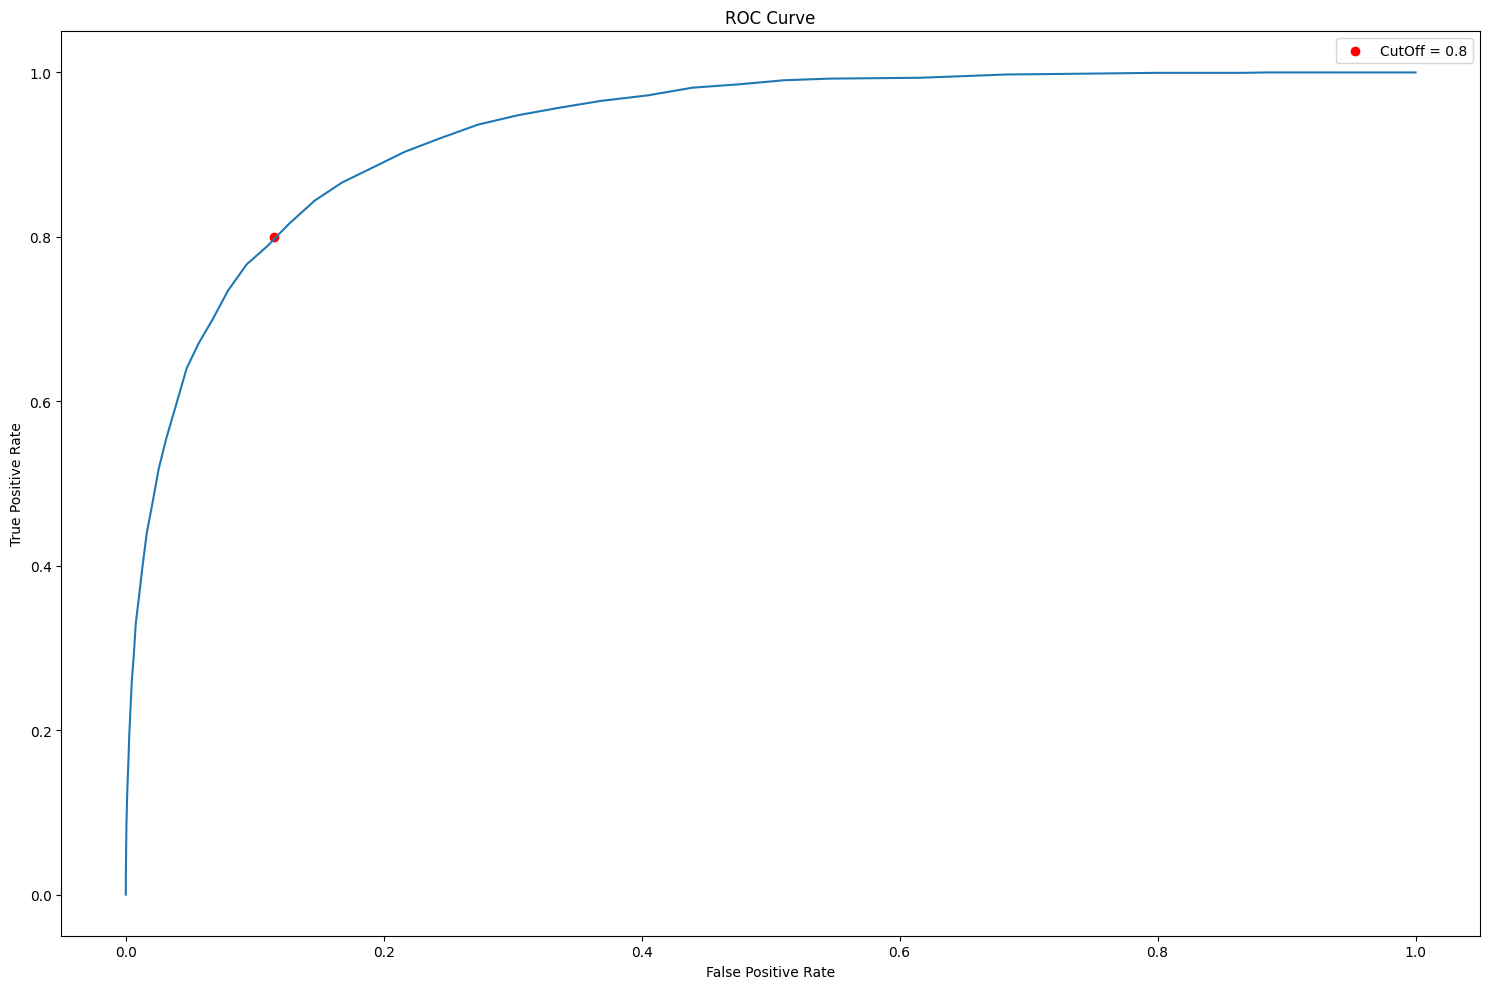

In [730]:
from scipy import interpolate
#Roc Curve
pos_rate = 0.8

def ROC_curve(data_A, data_B, n_points):
    
    thresholds = np.linspace(min(min(data_A), min(data_B)), max(max(data_A), max(data_B)), n_points)
    
    TPR = []
    FPR = []
    i = 0
    for t in thresholds:
        TPR.append(np.sum(data_A > t) / len(data_A))
        FPR.append(np.sum(data_B > t) / len(data_B))

        if i != 0 and TPR[i] <= pos_rate and TPR[i-1] >= pos_rate:
            cut = t
        i += 1
    # for i in range(len(TPR)):
    #     if TPR[i] >= pos_rate and TPR[i-1] <= pos_rate:
    #         cut = TPR[i]
    #         break
    
        
    return TPR, FPR, cut

TPR, FPR, cut = ROC_curve(fischer_P_signal, fischer_P_noise, 100)
print(cut)

fig_roc, ax_roc = plt.subplots(figsize=(15, 10))
ax_roc.plot(FPR, TPR)
ax_roc.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
#I wanna plot a point at the point where the TPR is 0.8
ax_roc.scatter(0.115, 0.8, color='red', label='CutOff = 0.8')
ax_roc.legend(loc='best')
fig_roc.tight_layout()

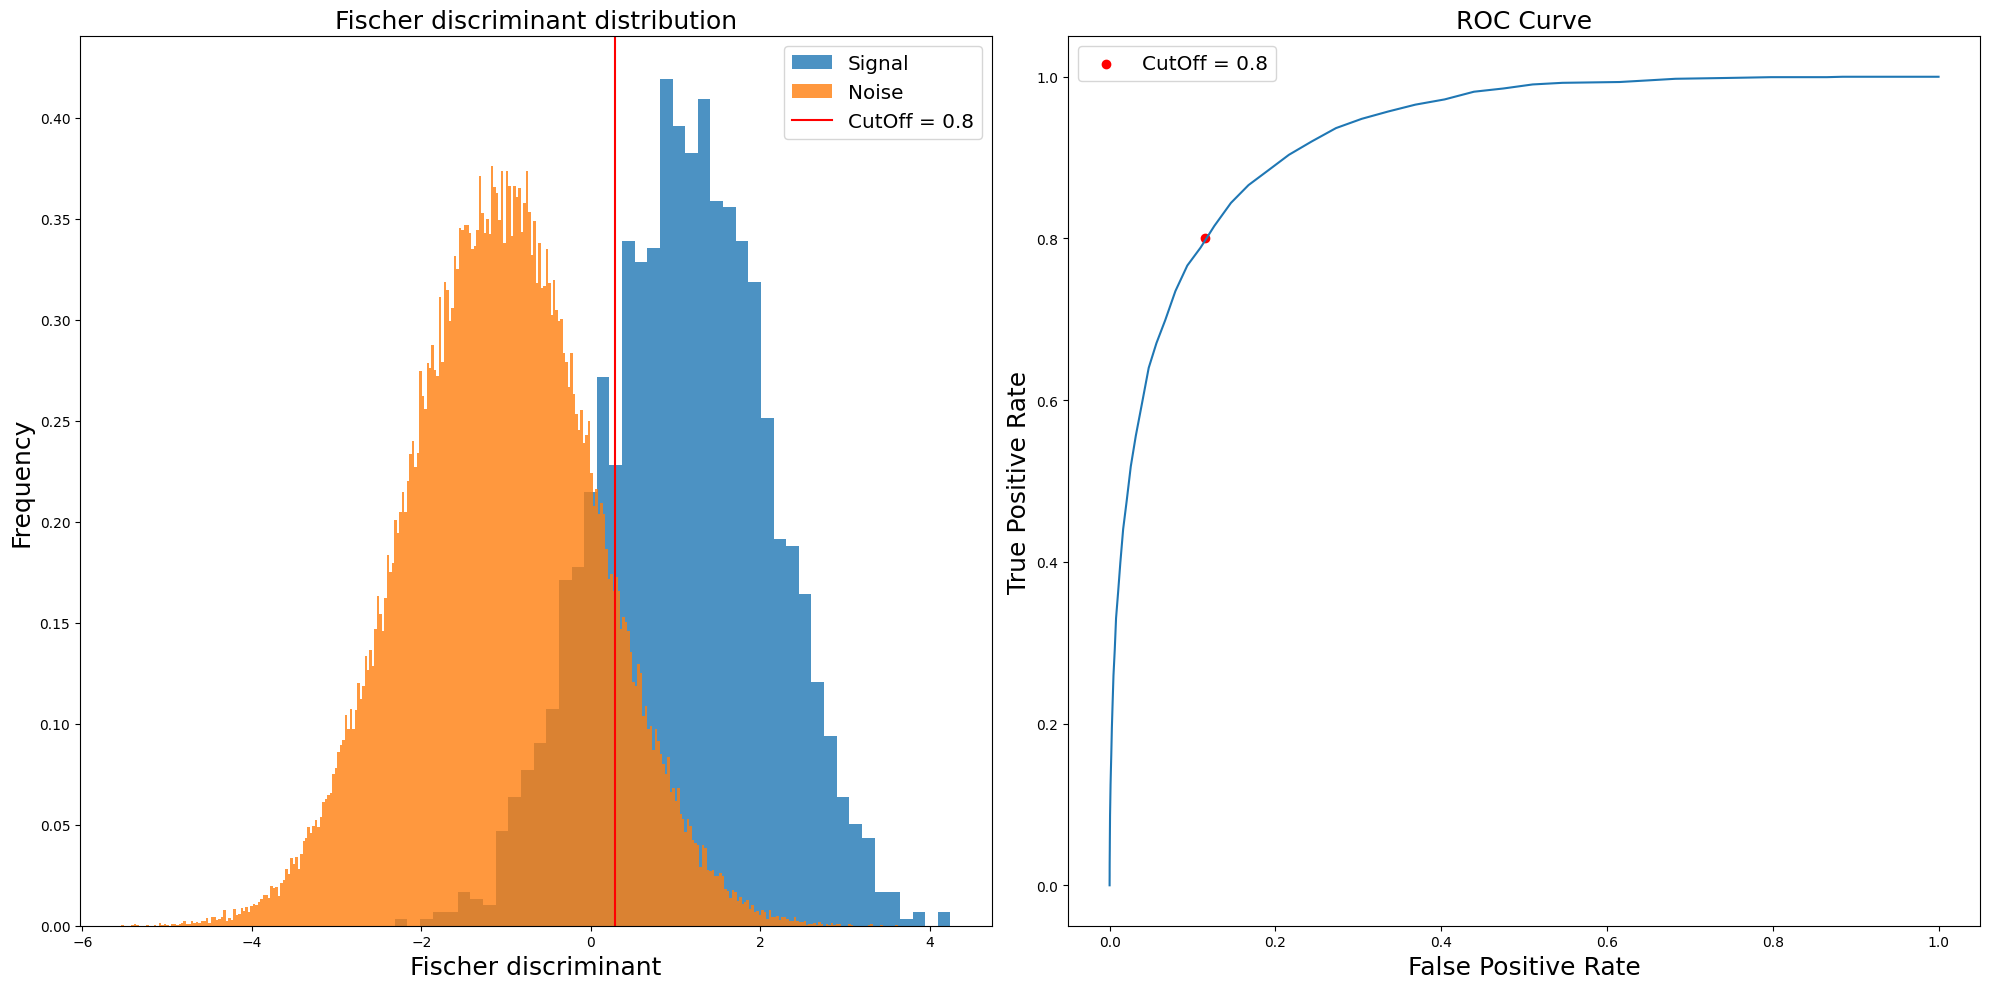

In [731]:
fig_fischer, ax_fischer = plt.subplots(1,2,figsize=(20, 10))
ax_fischer[0].hist(fischer_P_signal, bins=int(np.sqrt(len(fischer_P_signal))), alpha=0.8, density=True, label='Signal')
ax_fischer[0].hist(fischer_P_noise, bins=int(np.sqrt(len(fischer_P_noise))), alpha=0.8, density = True, label='Noise')
ax_fischer[0].axvline(cut, color='red', label='CutOff = 0.8')
ax_fischer[0].set(xlabel='Fischer discriminant', ylabel='Frequency', title='Fischer discriminant distribution')
ax_fischer[0].set_xlabel('Fischer discriminant', fontsize=18)
ax_fischer[0].set_ylabel('Frequency', fontsize=18)
ax_fischer[0].set_title('Fischer discriminant distribution', fontsize=18)
ax_fischer[0].legend(loc='best', fontsize='x-large')

ax_fischer[1].plot(FPR, TPR)
ax_fischer[1].scatter(0.115, 0.8, color='red', label='CutOff = 0.8')
ax_fischer[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
ax_fischer[1].set_xlabel('False Positive Rate', fontsize=18)
ax_fischer[1].set_ylabel('True Positive Rate', fontsize=18)
ax_fischer[1].set_title('ROC Curve', fontsize=18)
ax_fischer[1].legend(loc='best', fontsize='x-large')
fig_fischer.tight_layout()

plt.savefig('ROC_curve.png')


### • Selecting entries based only on P and R, how signiﬁcant can you get the H-peak ﬁt to be?

I wanna only use the values of frequency that are above the fischerdiscriminant cut off value that I found in the previous question for the Phase and Resonance.

In [732]:
F_sample = wf @ np.array([control_phase, control_resonance])

mask_signal = F_sample > cut
mask_noise = F_sample < cut
frequency_signal = control_freq[mask_signal]
frequency_noise = control_freq[mask_noise]
efficiency_control = len(frequency_signal) / len(control_freq)

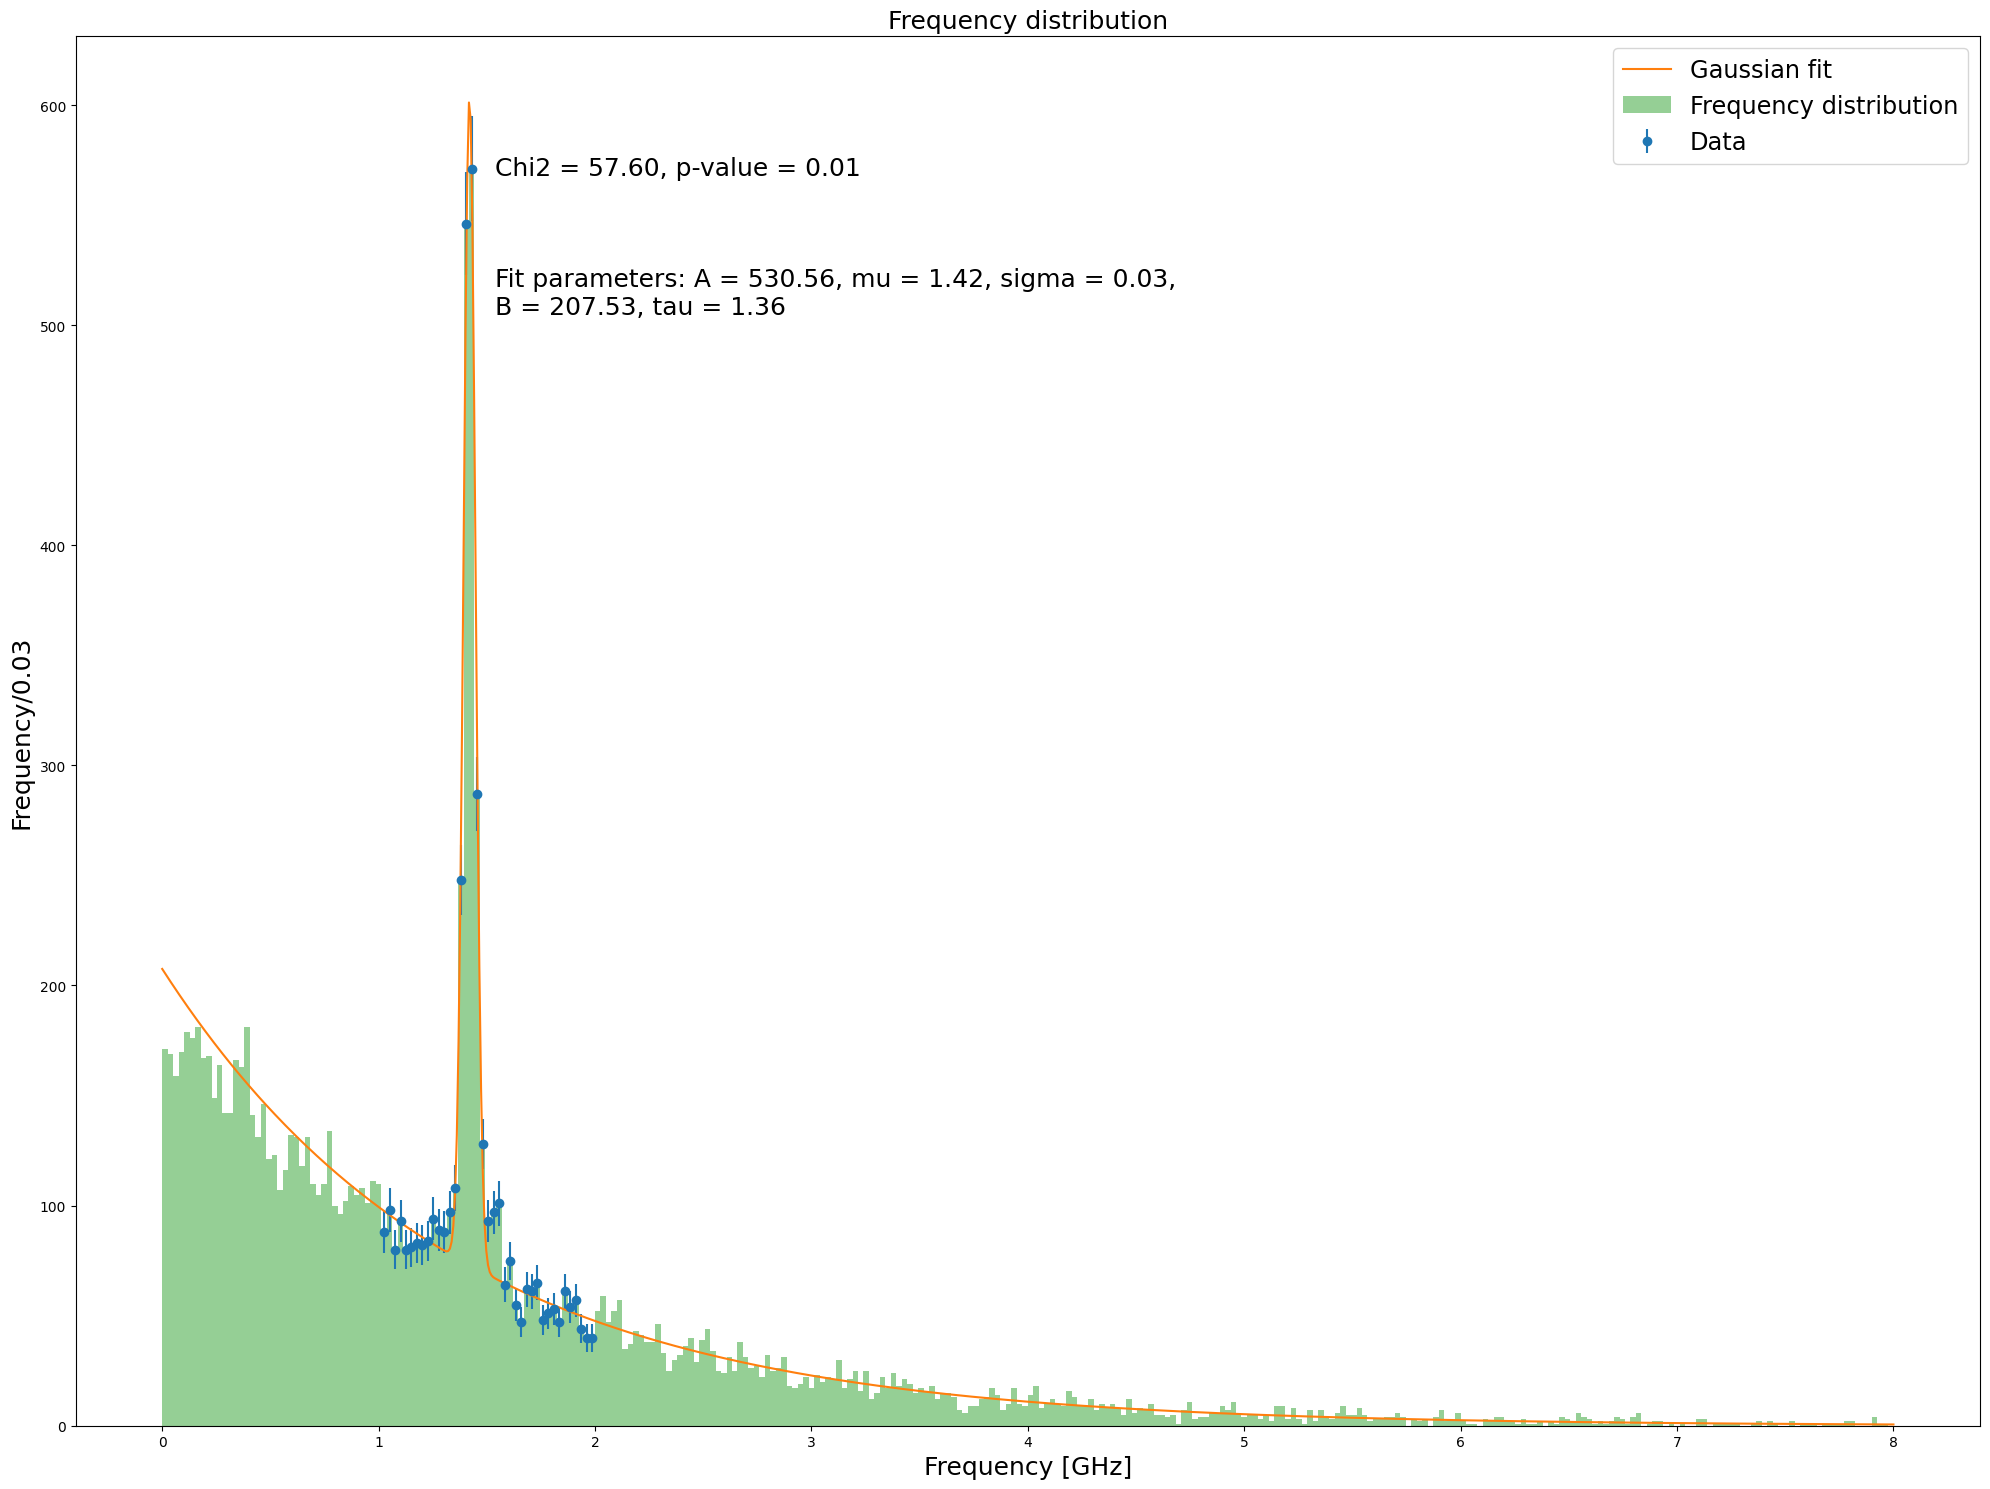

In [733]:
bins, edges = np.histogram(frequency_signal, bins=int(np.sqrt(100000)), range=(0, 8))
x = (edges[1:] + edges[:-1]) / 2
y = bins
yerr = np.sqrt(y)

mask = (x > 1) & (x < 2)
x = x[mask]
y = y[mask]
yerr = yerr[mask]

fit = cost.LeastSquares(x, y, yerr, fit_function)
mfit = Minuit(fit, A=200, mu=1.42, sigma=0.1, B = 1750, tau=0.5)
mfit.migrad()

x_fit = np.linspace(0, 8, 1000)
y_fit = fit_function(x_fit,*mfit.values)

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

fig, ax = plt.subplots(figsize=(20, 15))
ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label='Gaussian fit')
ax.hist(frequency_signal, bins=int(np.sqrt(100000)), alpha=0.5, range=(0,8), label="Frequency distribution")
ax.set(xlabel='Frequency [GHz]', ylabel='Frequency', title='Frequency distribution')
ax.set_xlabel('Frequency [GHz]', fontsize=18)
ax.set_ylabel(f'Frequency/{bin_width2:.2f}', fontsize=18)
ax.set_title('Frequency distribution', fontsize=18)
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.22, 0.9), xycoords='axes fraction', fontsize=18)
ax.annotate(f'Fit parameters: A = {mfit.values["A"]:.2f}, mu = {mfit.values["mu"]:.2f}, sigma = {mfit.values["sigma"]:.2f},\nB = {mfit.values["B"]:.2f}, tau = {mfit.values["tau"]:.2f}', (0.22, 0.8), xycoords='axes fraction', fontsize=18)
ax.legend(loc='best', fontsize='xx-large')
fig.tight_layout()

plt.savefig('Frequency_distribution_signal.png')


In [734]:
lower_bound = mfit.values['mu'] - mfit.values['sigma']
upper_bound = mfit.values['mu'] + mfit.values['sigma']
Entries_in_peak = frequency_signal[(frequency_signal > lower_bound) & (frequency_signal < upper_bound)].shape[0]
print(f'Entries total = {len(frequency_signal)}')
print(f'Entries in peak: {Entries_in_peak:.0f} +- {mfit.errors["A"]:.0f}')
print(f'Significancy of the peak: {Entries_in_peak/len(frequency_signal):.2%}')

Entries total = 12319
Entries in peak: 1186 +- 20
Significancy of the peak: 9.63%


### • Plot the real data frequency distribution, and search for a peak in the range [0.1,1.0] GHz.

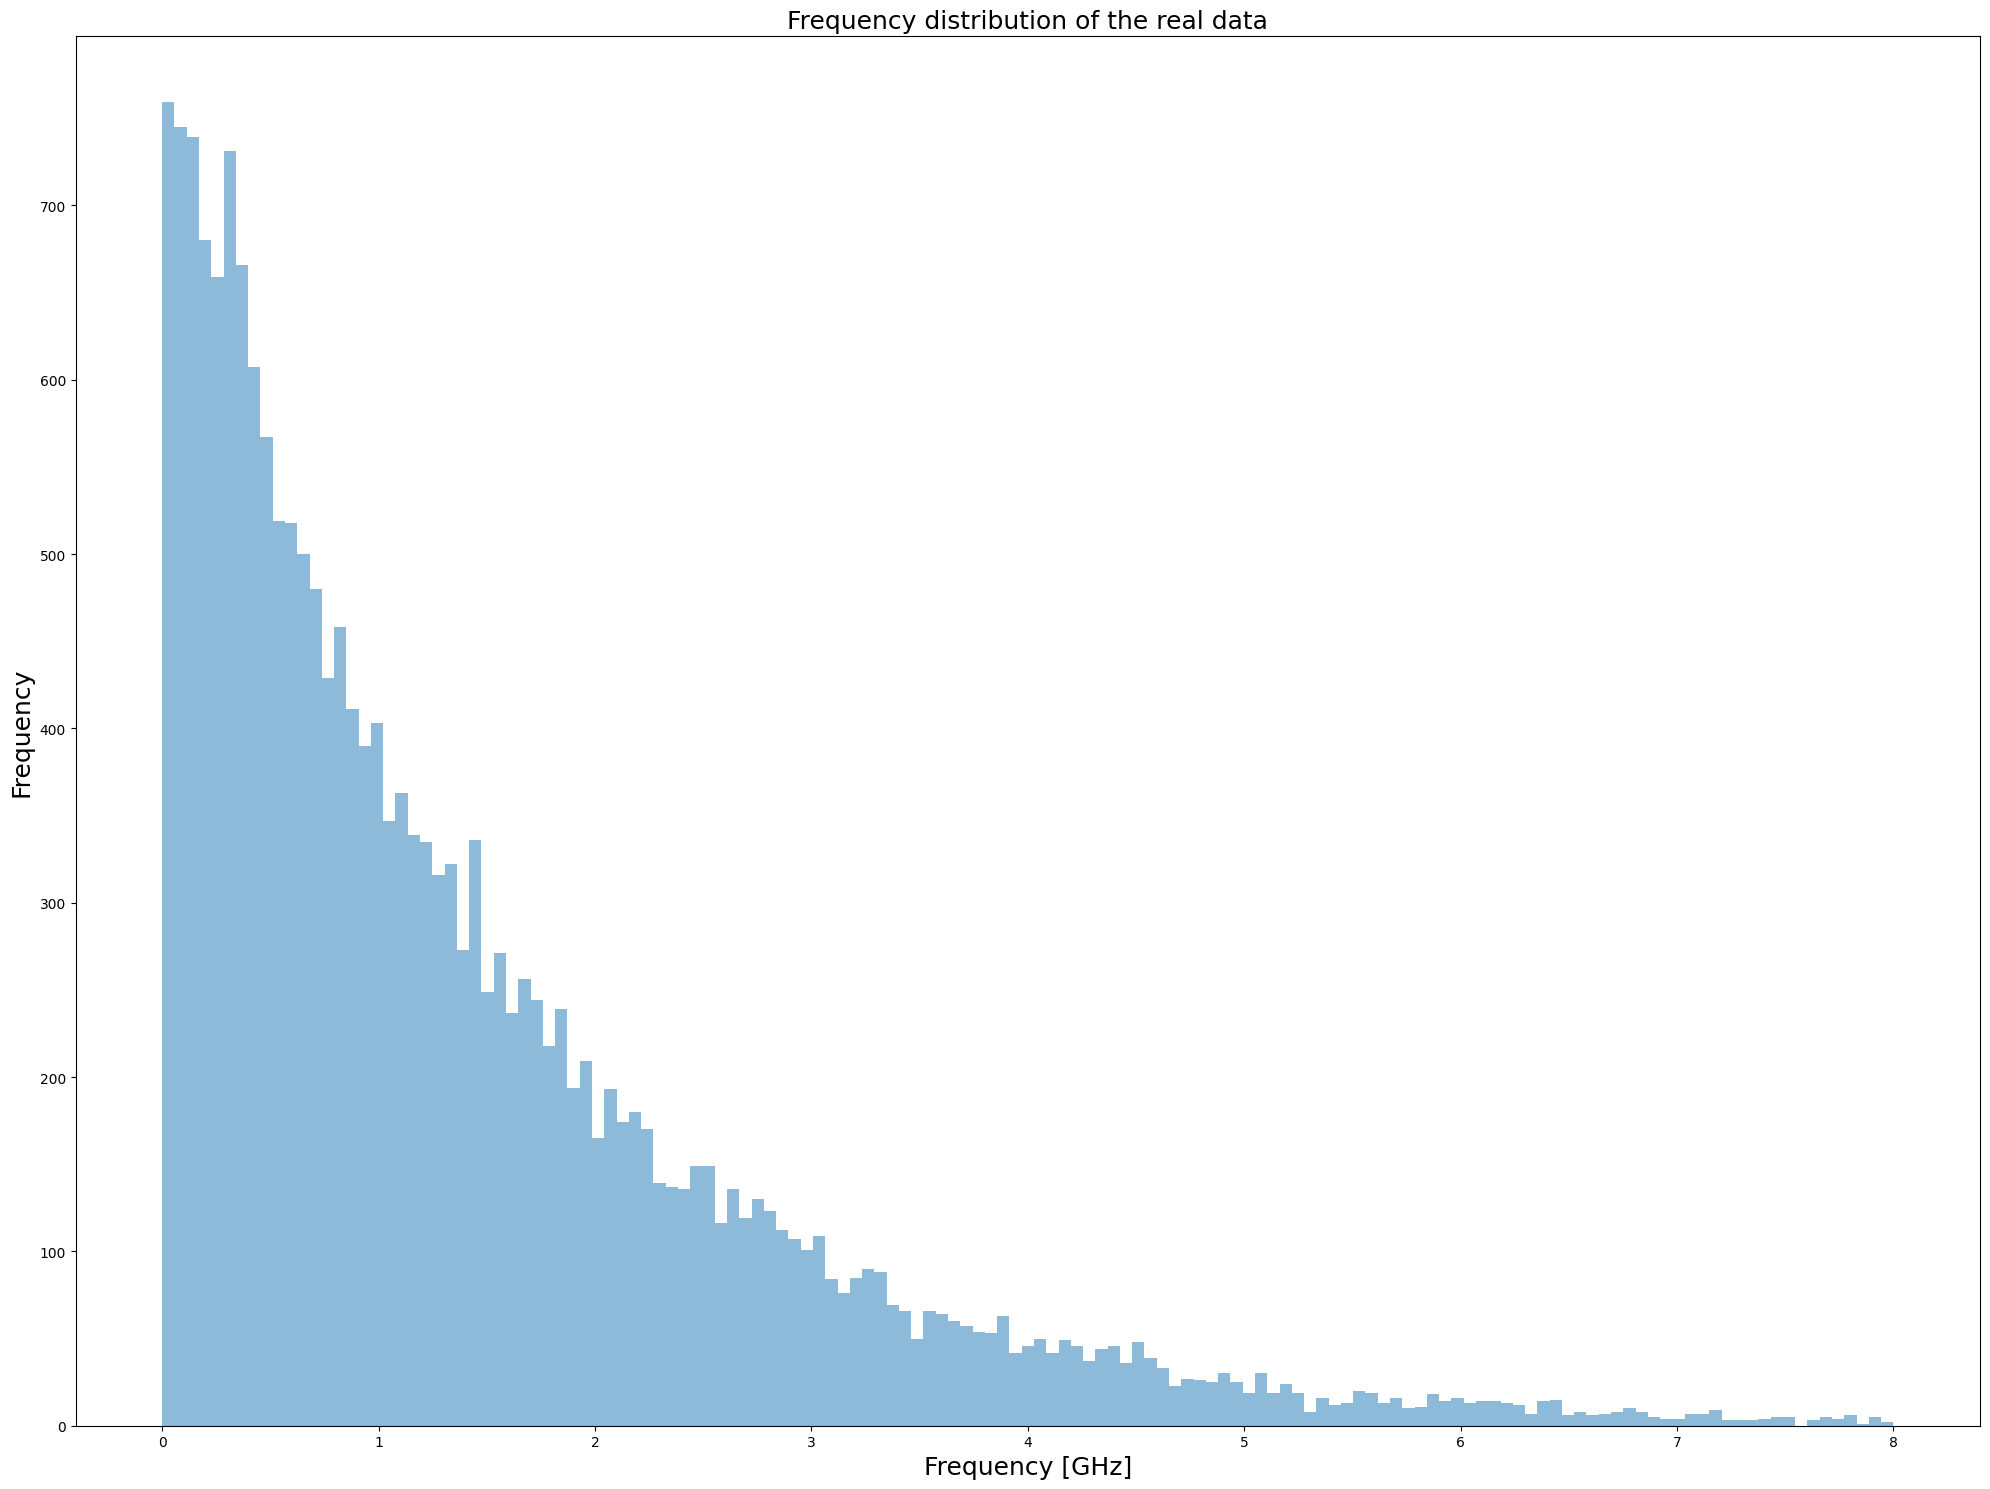

In [735]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.hist(real_freq, bins=int(np.sqrt(len(real_freq))), alpha=0.5, range=(0,8), label="Frequency distribution")
ax.set(xlabel="Frequency [GHz]", ylabel="Frequency", title="Frequency distribution")
ax.set_xlabel('Frequency [GHz]', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Frequency distribution of the real data', fontsize=18)
fig.tight_layout()

plt.savefig('Frequency_distribution_real.png')

I use the weight from the control data to calculate the fischer discriminant for the real data and assume the cut off value is the same as for the control data.

In [736]:
print(wf)
F_real = wf @ np.array([real_phase, real_resonance])

mask_signal_real = F_real > cut
mask_noise_real = F_real < cut
print(real_freq.shape)
frequency_signal = real_freq[mask_signal_real]
print(frequency_signal.shape)
frequency_noise = real_freq[mask_noise_real]
print(frequency_noise.shape)
efficiency_real = len(frequency_signal) / len(real_freq)

[-0.46483767  0.38510219]
(20000,)
(2378,)
(17622,)


2378
96
bin width: 0.02
<ValueView A=39.421353307203844 mu=0.3268497980028864 sigma=0.02811378218780076 B=31.98354834218574 tau=1.15000215762636>


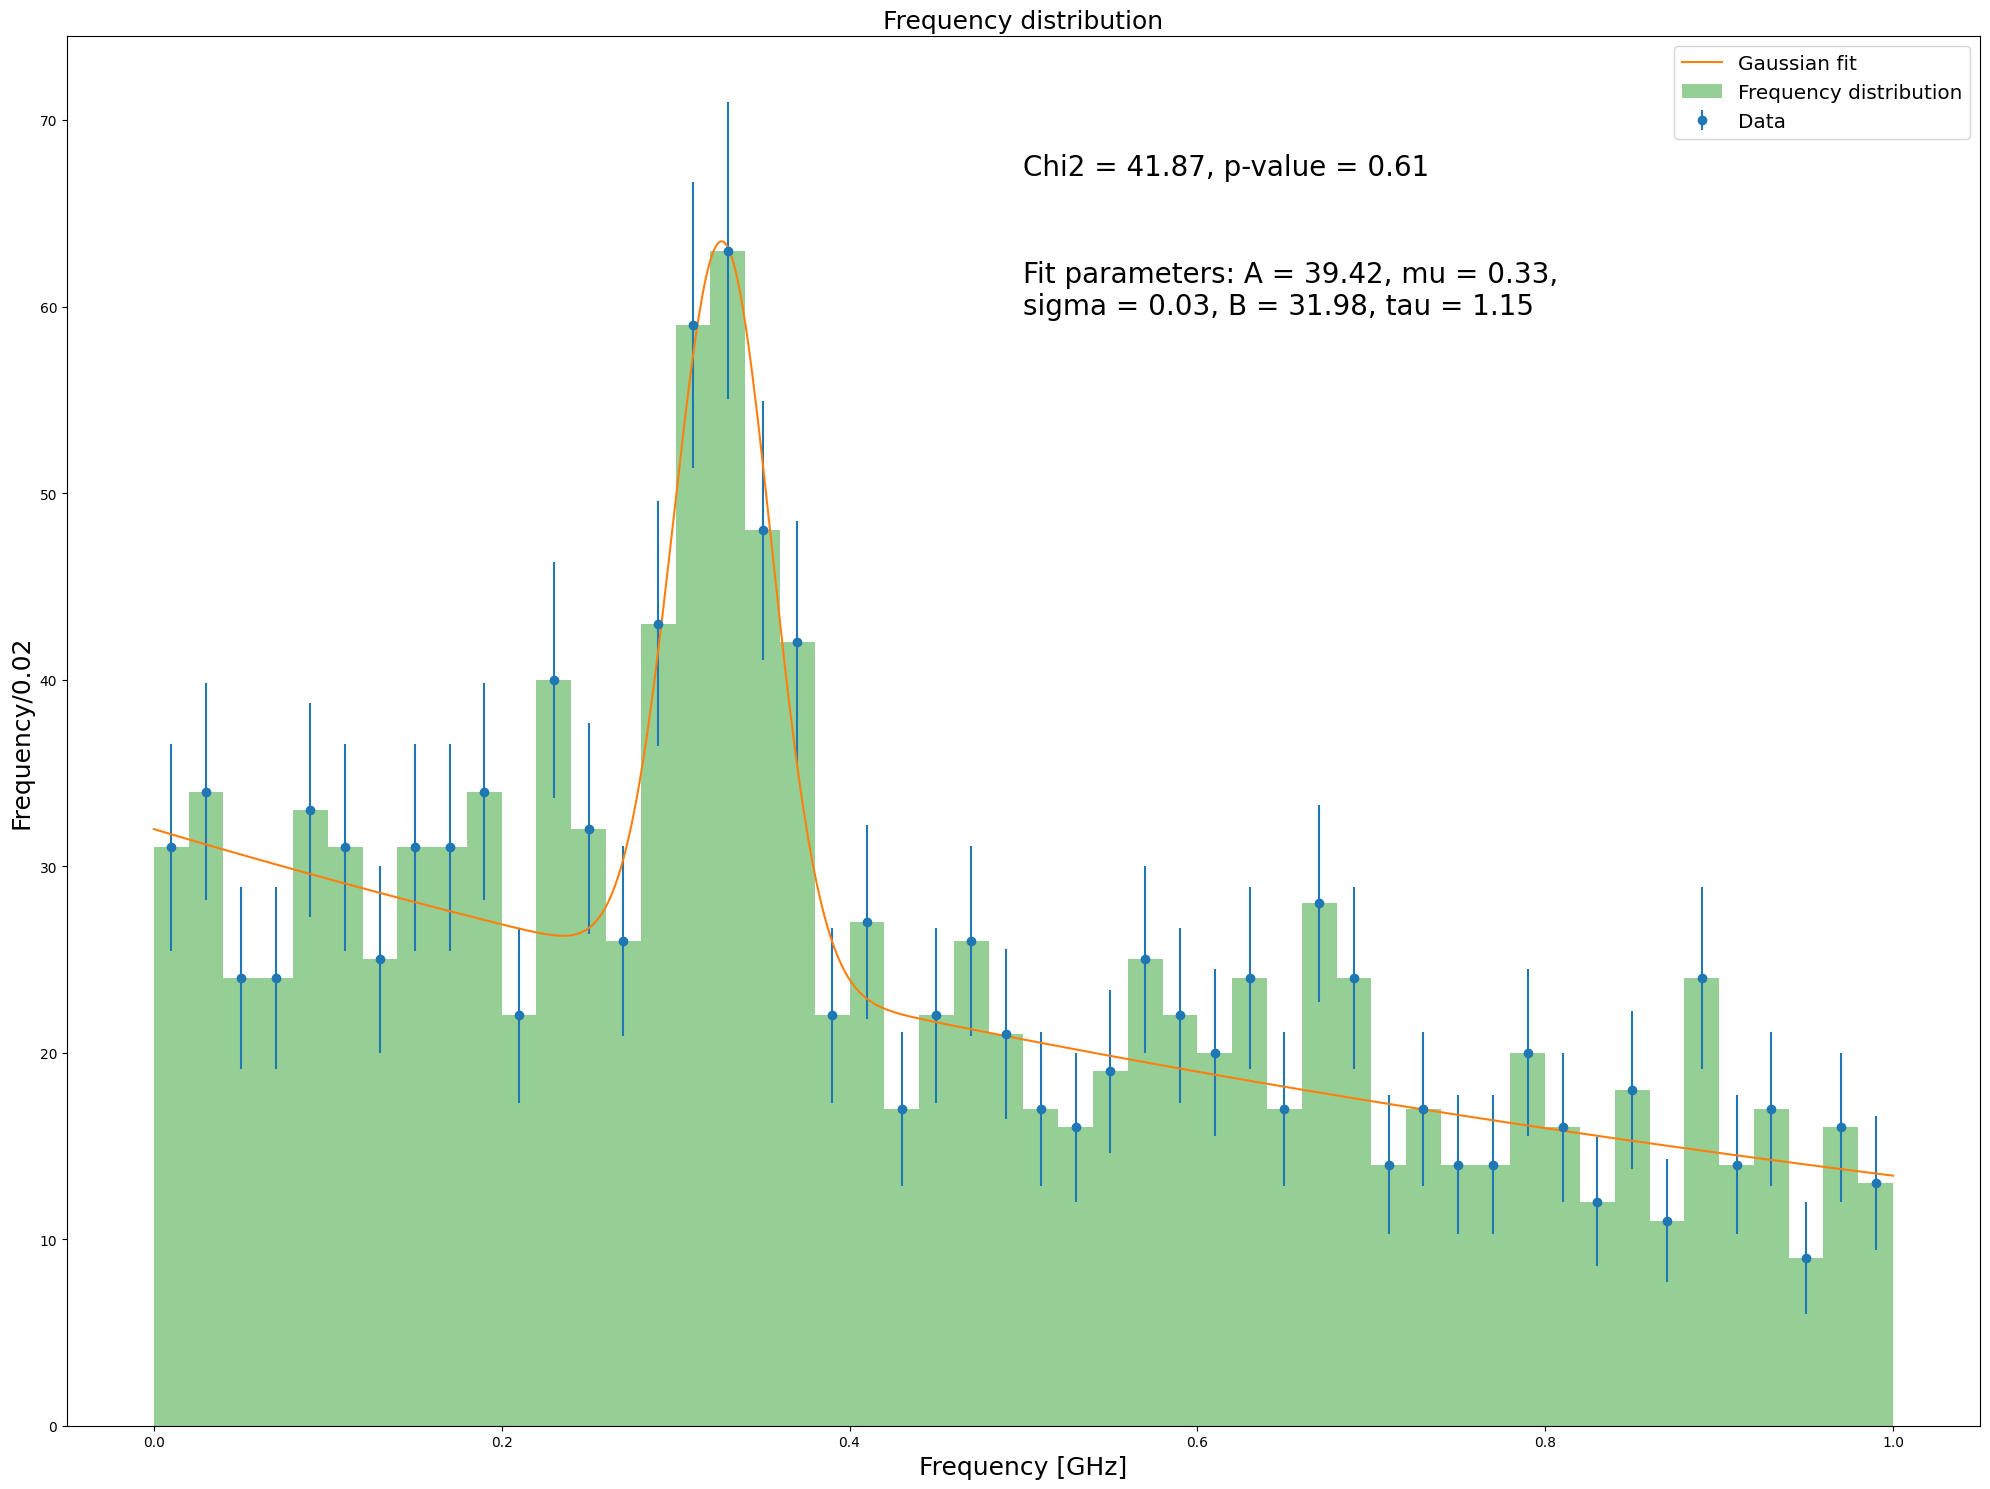

In [737]:
def fit_function(x, A, mu, sigma, B, tau):
    return gaussian(x, A, mu, sigma) + exponential(x, B, tau)

print(len(frequency_signal))
print(int(np.sqrt(len(frequency_signal)))*2)

counts, edges = np.histogram(frequency_signal, bins=50, range=(0, 1))
x = (edges[1:] + edges[:-1]) / 2
bin_width = edges[1] - edges[0]
print('bin width:', bin_width)
x = x
y = counts
yerr = np.sqrt(y)

fit = cost.LeastSquares(x, y, yerr, fit_function)
mfit = Minuit(fit, A=170, mu=0.3, sigma=0.1, B = 80, tau=0.1)
mfit.migrad()

x_fit = np.linspace(0, 1, 1000)
y_fit = fit_function(x_fit,*mfit.values)

print(mfit.values)

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

fig, ax = plt.subplots(figsize=(20, 15))
ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label='Gaussian fit')
ax.hist(frequency_signal, bins=50, alpha=0.5, range=(0,1), label="Frequency distribution")
ax.set(xlabel='Frequency [GHz]', ylabel='Frequency', title='Frequency distribution')
ax.set_xlabel('Frequency [GHz]', fontsize=18)
ax.set_ylabel(f'Frequency/{bin_width:.2f}', fontsize=18)
ax.set_title('Frequency distribution', fontsize=18)
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.5, 0.9), xycoords='axes fraction', fontsize=20)
ax.annotate(f'Fit parameters: A = {mfit.values["A"]:.2f}, mu = {mfit.values["mu"]:.2f}, \nsigma = {mfit.values["sigma"]:.2f}, B = {mfit.values["B"]:.2f}, tau = {mfit.values["tau"]:.2f}', (0.5, 0.8), xycoords='axes fraction', fontsize=20)
ax.legend(loc='best', fontsize='x-large')
fig.tight_layout()
plt.savefig('Frequency_distribution_signal_real.png')


### • How many signal entries do you estimate there to be in the peak? Do you ﬁnd it signiﬁcant?

In [738]:
print(mfit.values['A'], mfit.errors['A'])
print(bin_width)
lower_bound = mfit.values['mu'] - mfit.values['sigma']
upper_bound = mfit.values['mu'] + mfit.values['sigma']
Entries_in_peak = frequency_signal[(frequency_signal > lower_bound) & (frequency_signal < upper_bound)].shape[0]
print(f'Entries in peak: {Entries_in_peak:.0f} +- {mfit.errors["A"]:.0f}')
print(f'Significancy of the peak: {Entries_in_peak/len(frequency_signal):.2%}')

39.421353307203844 5.820551448682968
0.02
Entries in peak: 164 +- 6
Significancy of the peak: 6.90%


Since the error is significantly low and is not within i.e. 5 sigma of zero, I would say that the peak is significant.

### • Correcting for the signal selection efficiency when selecting events baseed on P and R, how many signal entries do you estimate there was in the data originally?

In [739]:
print(f'Effiency of control data: {efficiency_control:.2f}')
print(f'Actual entries using Fischer = {len(frequency_signal)}')

real_sample_entries = efficiency_control * len(real_freq)
print(f'Entries of signal in real data using efficency of control data: {real_sample_entries:.0f}')

Effiency of control data: 0.12
Actual entries using Fischer = 2378
Entries of signal in real data using efficency of control data: 2464


I tried using ML to see how the data was seperated

In [740]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

control_sample = Signal[:100000]

X = control_sample[[' Frequency', '    Resonance']]
Y = control_sample['   Type']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(np.array(X_train), Y_train)

Y_pred = lda.predict(np.array(X_test))

precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
f1 = f1_score(Y_test, Y_pred, average='weighted')
confusion = confusion_matrix(Y_test, Y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Confusion matrix:\n{confusion}')




Precision: 0.96
Recall: 0.98
F1-score: 0.97
Confusion matrix:
[[48991     0]
 [ 1009     0]]


c:\Users\Elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: Measures the accuracy of positive predictions.
Recall: Measures the model's ability to identify all relevant instances.
F1 Score: Balances precision and recall into a single metric.
Confusion Matrix: Summarizes the counts of true positive, true negative, false positive, and false negative predictions

## 5.2 (10 points) The ﬁle www.nbi.dk/∼petersen/data DecayTimes.csv contains the measured decay times ($t_i$ in s) of a Bohrium isotope. The true decay times follow an exponential function, but the measurement of the decay times given have a Gaussian resolution G(0, σ) (thus no bias)

### • Plot the distribution of decay times, and calculate the mean and median with uncertainty

In [741]:
DecayTimes = pd.read_csv('data_DecayTimes.csv')

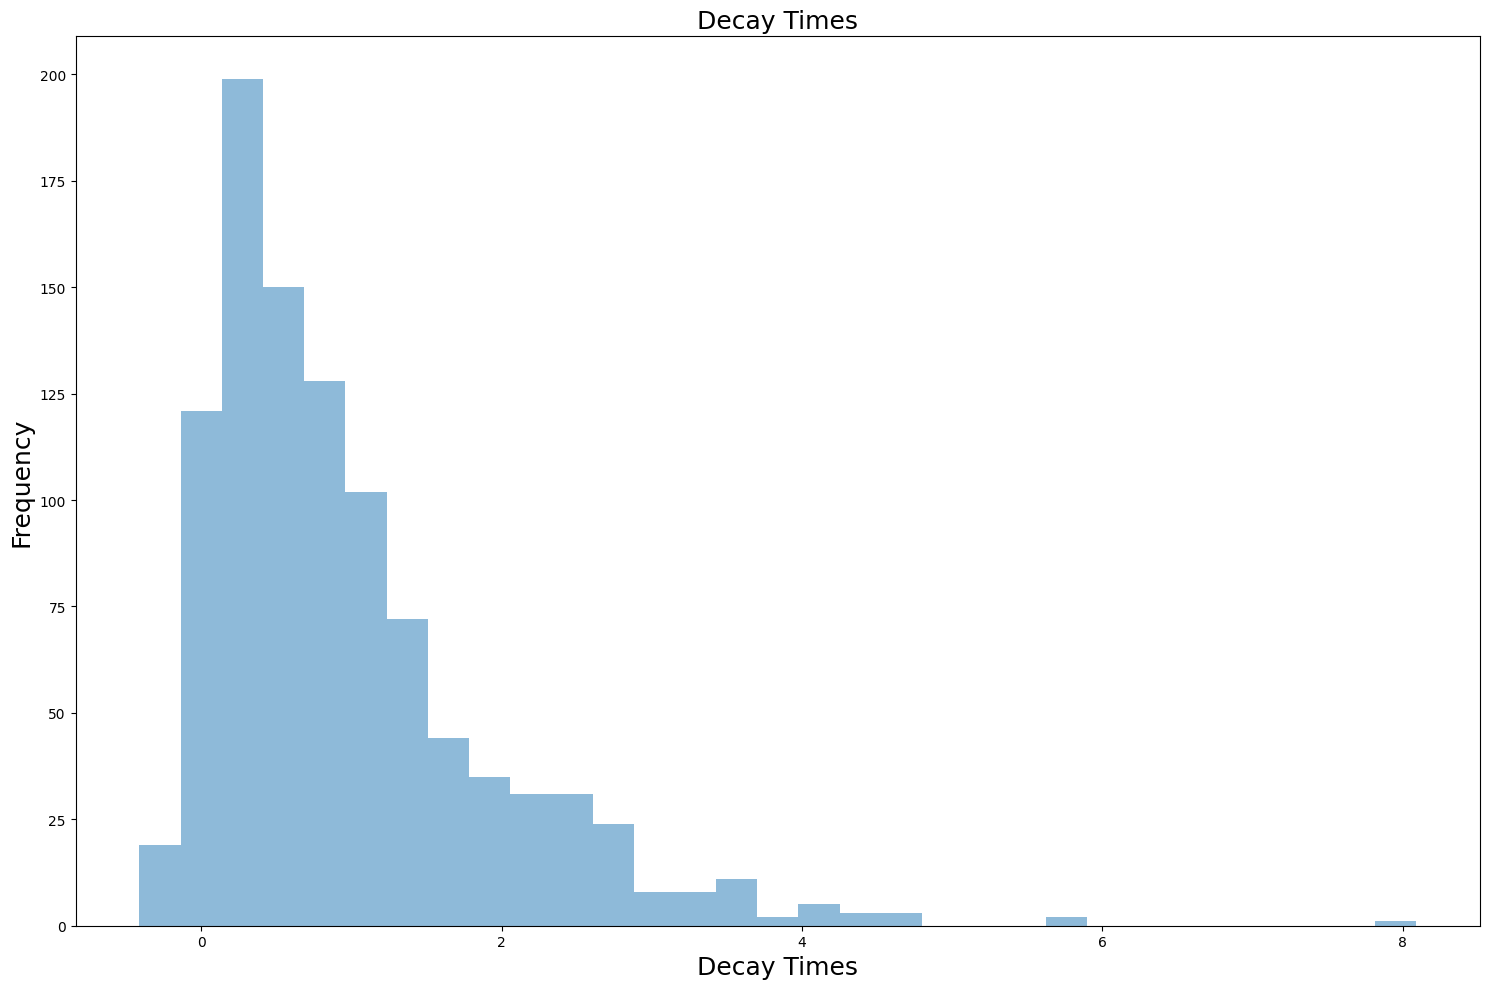

In [742]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(DecayTimes.values, bins= int(np.sqrt(len(DecayTimes.values))), alpha=0.5, label="Decay Times")
ax.set(xlabel="Decay Times", ylabel="Frequency", title="Decay Times")
ax.set_xlabel('Decay Times', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Decay Times', fontsize=18)
fig.tight_layout()
plt.savefig('DecayTimes.png')


In [743]:
mean_decay = np.mean(DecayTimes.values)
std_decay = np.std(DecayTimes.values)
mean_uncertainty = std_decay / np.sqrt(len(DecayTimes.values))

median_decay = np.median(DecayTimes.values)
#This only works for a normal distribution!
median_uncertainty = 1.253 * std_decay / np.sqrt(len(DecayTimes.values))

print(f'Mean decay time: {mean_decay:.2f} +- {mean_uncertainty:.2f}')
print(f'Median decay time: {median_decay:.2f} +- {median_uncertainty:.2f}')

Mean decay time: 0.96 +- 0.03
Median decay time: 0.70 +- 0.04


### • Give a rough estimate of the decay time τ from fitting the high-t tail of the distribution.

I will here use an exponential function to fit the the tail of the distribution and estimate the decay time $\tau$.

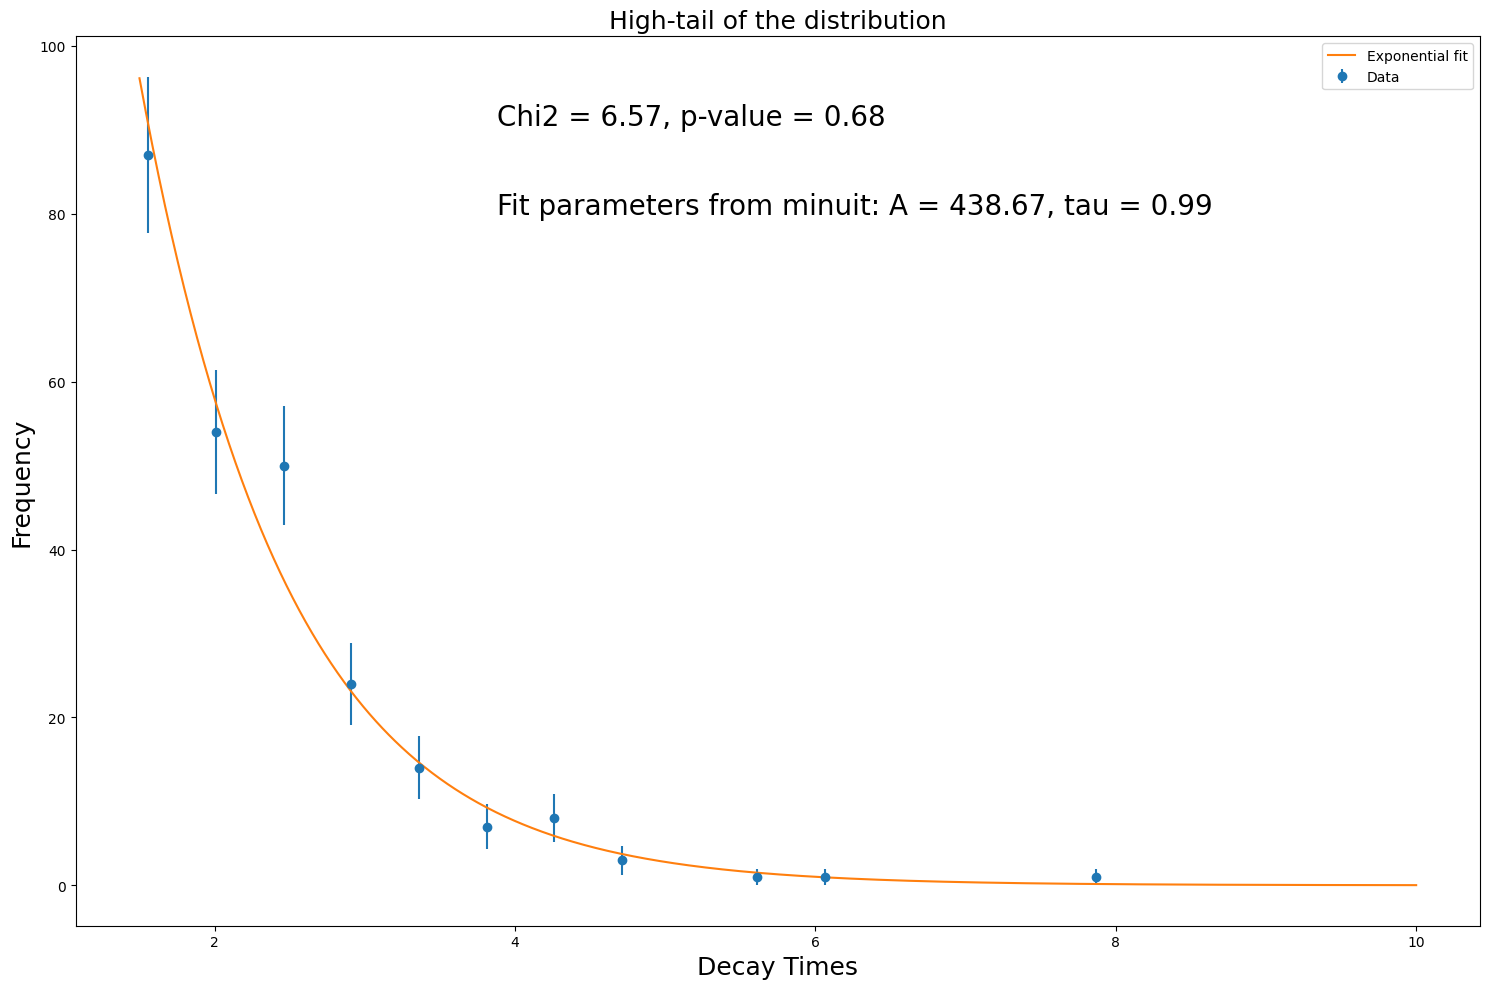

In [744]:
def exponential(x, A, tau):
    return A * np.exp(-x / tau)

#High-t tail of the distribution
threshold = np.percentile(DecayTimes.values, 75)
DecayTimes_high = DecayTimes[DecayTimes.values > threshold]

counts, edges = np.histogram(DecayTimes_high.values, bins=int(np.sqrt(len(DecayTimes_high.values))))
x = (edges[1:] + edges[:-1]) / 2
x = x[counts > 0]
y = counts[counts > 0]
yerr = np.sqrt(y)

fit = cost.LeastSquares(x, y, yerr, exponential)

mfit = Minuit(fit, A=200, tau=2)
mfit.migrad()

x_fit = np.linspace(1.5, 10, 1000)
y_fit = exponential(x_fit, *mfit.values)

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

fig, ax = plt.subplots(figsize=(15, 10))
ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label='Exponential fit')
ax.set(xlabel='Decay Times', ylabel='Frequency', title='High-tail of the distribution')
ax.set_xlabel('Decay Times', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('High-tail of the distribution', fontsize=18)
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.3, 0.9), xycoords='axes fraction', fontsize= 20)
ax.annotate(f'Fit parameters from minuit: A = {mfit.values["A"]:.2f}, tau = {mfit.values["tau"]:.2f}', (0.3, 0.8), xycoords='axes fraction', fontsize = 20)
ax.legend(loc='best')
fig.tight_layout()

plt.savefig('High_tail.png')



### • Fit the entire distribution, and (re-)assess the estimated values of τ and σ

Here I used the modified Gaussion distribution to fit the data and estimate the values of $\tau$ and $\sigma$. https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution 

Value of tau from high-tail fit: 0.9882300627390752
Value of tau from EMG fit: 0.9410085692926219

Value of sigma from calculating std: 0.9550883119272288
Value of sigma from EMG fit: 0.1888042651055182


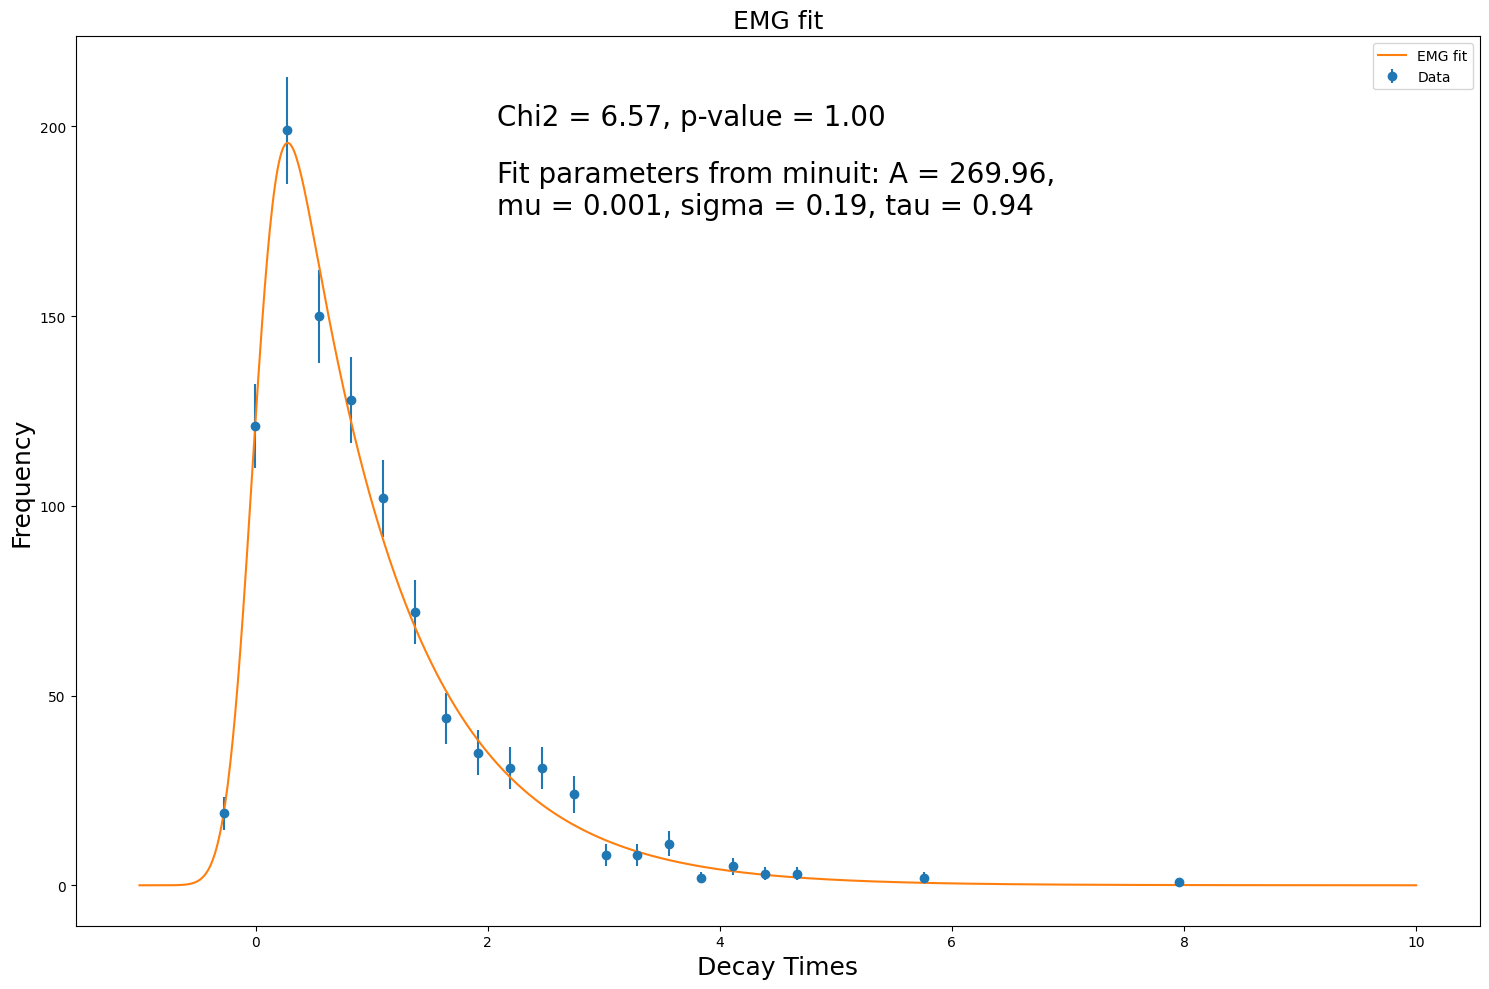

In [745]:
from scipy.special import erfc
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

# def Gauss_exp(x, A, mu, sigma, B, tau):
#     return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + B * np.exp(-x / tau)

def emg(x, A, mu, sigma, tau):
    return (A / (2 * tau)) * np.exp((mu - x) / tau + (sigma**2) / (2 * tau**2)) * erfc((mu - x) / (np.sqrt(2) * sigma) + sigma / (np.sqrt(2) * tau))


counts, edges = np.histogram(DecayTimes.values, bins=int(np.sqrt(len(DecayTimes.values))))
x = (edges[1:] + edges[:-1]) / 2
x = x[counts > 0]
y = counts[counts > 0]
yerr = np.sqrt(y)

fit = cost.LeastSquares(x, y, yerr,emg)
mfit_after = Minuit(fit, A=y.max(), mu=mean_decay, sigma=std_decay, tau=1)
# mfit = Minuit(fit, A = 200, mu = mean_decay, sigma = std_decay, B = 200, tau = 1)
mfit_after.migrad()

x_fit = np.linspace(-1, 10, 1000)
y_fit = emg(x_fit, *mfit_after.values)

chi2 = mfit.fval
ndof = len(x) - len(mfit.values)
prob = stats.chi2.sf(chi2, ndof)

fig, ax = plt.subplots(figsize=(15, 10))
ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label='EMG fit')
ax.set(xlabel='Decay Times', ylabel='Frequency', title='EMG fit')
ax.set_xlabel('Decay Times', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('EMG fit', fontsize=18)
ax.annotate(f'Chi2 = {chi2:.2f}, p-value = {prob:.2f}', (0.3, 0.9), xycoords='axes fraction', fontsize= 20)
ax.annotate(f'Fit parameters from minuit: A = {mfit_after.values["A"]:.2f}, \nmu = {mfit_after.values["mu"]:.3f}, sigma = {mfit_after.values["sigma"]:.2f}, tau = {mfit_after.values["tau"]:.2f}', (0.3, 0.8), xycoords='axes fraction', fontsize = 20)
ax.legend(loc='best')
fig.tight_layout()

plt.savefig('EMG_fit.png')

print(r'Value of tau from high-tail fit:', mfit.values['tau'])
print(r'Value of tau from EMG fit:', mfit_after.values['tau'])
print('')
print(r'Value of sigma from calculating std:', std_decay)
print(r'Value of sigma from EMG fit:', mfit_after.values['sigma'])

